# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [2]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [3]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

In [4]:
#data = np.load("/kaggle/input/mars-for-students/mars_for_students.npz")
data = np.load("mars_for_students_cleaned.npz")

#X_train = data['X_train']
#y_train = data['y_train']

#X_test = data["X_test"]

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]


X_train = tf.clip_by_value(X_train[..., np.newaxis] / 255.0 * 1.5, 0.0, 1.0)
y_train = y_train[..., np.newaxis]
X_test  = tf.clip_by_value(X_test[..., np.newaxis] / 255.0 * 1.5, 0.0, 1.0)

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128, 1)
Training y shape: (2505, 64, 128, 1)
Test X shape: (10022, 64, 128, 1)


## Prepare the data


In [5]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [6]:
LEARNING_RATE = 5e-3
EPOCHS = 1000
PATIENCE = 30
BATCH_SIZE = 64
SPLITS_SIZE = 300
SEED = 42
NUM_CLASSES = 5

X_train = X_train.numpy() if isinstance(X_train, tf.Tensor) else np.array(X_train)
y_train = y_train.numpy() if isinstance(y_train, tf.Tensor) else np.array(y_train)

from sklearn.model_selection import train_test_split

#train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
#    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
#)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)


print(f"Train set shape: {train_img.shape}")
print(f"Validation image set shape: {val_img.shape}")
print(f"Validation masks set shape: {val_lbl.shape}")
# print(f"Test set shape: {test_img.shape}")




Train set shape: (2205, 64, 128, 1)
Validation image set shape: (300, 64, 128, 1)
Validation masks set shape: (300, 64, 128, 1)


## Augmentation

In [7]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label

from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    # dataset = dataset.map(
    #     lambda x, y: (x, apply_category_mapping(y)),
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    if augment:

        augmentations = A.Compose([
            #A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Flip(),
            # A.Transpose(),
            #A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                #A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
            A.RandomGridShuffle(grid = (3,3), always_apply=False, p = 0.3),
            A.RandomBrightnessContrast(brightness_limit = 0.2,
                                        contrast_limit = 0.2,
                                        always_apply = False,
                                        p = 0.2
                                      ),
            #A.Sharpen(alpha=(0.2, 0.5), lightness = (0.5, 1.0), always_apply=False, p = 0.5),
            A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
            # A.RandomCrop(height=64, width=128, p=1),
            # A.OneOf([
            #     #A.CLAHE(clip_limit=2),
            #     A.RandomBrightnessContrast(),
            # ], p=0.3),
            # A.HueSaturationValue(p=0.3),
        ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

#test_dataset = make_dataset(
#    test_img, test_lbl,
#    batch_size=BATCH_SIZE,
#    shuffle=False
#)
print("Datasets created!")

def remove_extra_dim(images, labels):
    labels = tf.squeeze(labels, axis=-1)  # Supprime la dimension supplémentaire
    return images, labels

train_dataset = train_dataset.map(remove_extra_dim)

val_dataset = val_dataset.map(remove_extra_dim)

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break




Creating datasets...


<ipython-input-7-37951b13ec91>:120: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-7-37951b13ec91>:120: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-7-37951b13ec91>:120: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)


WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'float32'>


## Metric for simulation

In [9]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=(64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

# Model

In [10]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = tfkl.Conv2D(filters, kernel_size=(num_row, num_col), strides=strides, padding=padding, use_bias=False, name=name)(x)
    x = tfkl.BatchNormalization(axis=3, scale=False)(x)

    if activation is None:
        return x

    x = tfkl.Activation(activation, name=name)(x)
    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = tfkl.Conv2DTranspose(filters, kernel_size=(num_row, num_col), strides=strides, padding=padding)(x)
    x = tfkl.BatchNormalization(axis=3, scale=False)(x)
    return x


def MultiResBlock(U, inp, alpha=1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corresponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) + int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3, activation='relu', padding='same')
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3, activation='relu', padding='same')
    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3, activation='relu', padding='same')

    out = tfkl.concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = tfkl.BatchNormalization(axis=3)(out)

    out = tfkl.add([shortcut, out])
    out = tfkl.Activation('relu')(out)
    out = tfkl.BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- number of filters
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = tfkl.add([shortcut, out])
    out = tfkl.Activation('relu')(out)
    out = tfkl.BatchNormalization(axis=3)(out)

    for i in range(length - 1):
        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = tfkl.add([shortcut, out])
        out = tfkl.Activation('relu')(out)
        out = tfkl.BatchNormalization(axis=3)(out)

    return out

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tfkl.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    return x

class RepeatElementsLayer(tfk.Layer):
    def __init__(self, rep, axis=3, **kwargs):
        super(RepeatElementsLayer, self).__init__(**kwargs)
        self.rep = rep
        self.axis = axis

    def call(self, inputs):
        return tf.keras.backend.repeat_elements(inputs, self.rep, axis=self.axis)

    def get_config(self):
        config = super(RepeatElementsLayer, self).get_config()
        config.update({
            "rep": self.rep,
            "axis": self.axis
        })
        return config

def attention_block(x, gating, inter_shape):
    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = tfk.backend.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tfkl.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tfkl.add([upsample_g, theta_x])
    act_xg = tfkl.Activation('relu')(concat_xg)
    psi = tfkl.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tfkl.Activation('sigmoid')(psi)
    shape_sigmoid = tfk.backend.int_shape(sigmoid_xg)
    upsample_psi = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    repeat_layer = RepeatElementsLayer(rep= shape_x[3])
    upsample_psi = repeat_layer(upsample_psi)

    y = tfkl.multiply([upsample_psi, x])

    result = tfkl.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tfkl.BatchNormalization()(result)
    return result_bn

def create_aspp_decoder(input_tensor, output_channels, dilation_rates, name="aspp_module"):
    """
    Recreate the architecture using tfm.vision.decoders.ASPP.

    Args:
        input_tensor: Input tensor to the ASPP module.
        output_channels: Number of output channels for the final enhanced feature map.
        dilation_rates: List of dilation rates for 3x3 convolutions.
        name: Name for the ASPP module.

    Returns:
        Tensor after applying the ASPP decoder.
    """
    with tf.name_scope(name):


        out_0 = tfkl.Conv2D(256, (1, 1), activation='relu', kernel_initializer='lecun_uniform', dilation_rate=1, padding='same')(input_tensor)
        out_1 = tfkl.Conv2D(256, (3, 3), activation='relu', kernel_initializer='lecun_uniform', dilation_rate=1, padding='same')(input_tensor)
        out_2 = tfkl.Conv2D(256, (3, 3), activation='relu', kernel_initializer='lecun_uniform', dilation_rate=2, padding='same')(input_tensor)
        output_tensor = tfkl.Concatenate(axis=-1)([out_0, out_1, out_2])

        # Apply the ASPP module

        return output_tensor


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''

    inputs = tfk.Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)


    aspp_block5 = create_aspp_decoder(mresblock5, 32*16, [1, 2, 4])
    gating_res4 = gating_signal(aspp_block5, 32*8)
    att_res4 = attention_block(mresblock4, gating_res4, 32*8)
    up6 = tfkl.concatenate([tfkl.Conv2DTranspose(32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), att_res4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    aspp_block6 = create_aspp_decoder(mresblock6, 32*8, [1, 2, 4])
    gating_res3 = gating_signal(aspp_block6, 32*4)
    att_res3 = attention_block(mresblock3, gating_res3, 32*4)
    up7 = tfkl.concatenate([tfkl.Conv2DTranspose(32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), att_res3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    aspp_block7 = create_aspp_decoder(mresblock7, 32*4, [1, 2, 4])
    gating_res2 = gating_signal(aspp_block7, 32*2)
    att_res2 = attention_block(mresblock2, gating_res2, 32*2)
    up8 = tfkl.concatenate([tfkl.Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), att_res2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    aspp_block8 = create_aspp_decoder(mresblock8, 32*2, [1, 2, 4])
    gating_res1 = gating_signal(aspp_block8, 32)
    att_res1 = attention_block(mresblock1, gating_res1, 32)
    up9 = tfkl.concatenate([tfkl.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(mresblock8), att_res1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 5, 1, 1, activation='softmax')

    model = tfk.Model(inputs=[inputs], outputs=[conv10])

    return model


model = MultiResUnet(64,128, 1)
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=70)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 8)     │             72 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 128, 8)     │             24 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 64, 128, 8)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 128, 17)    │          1,224 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 128, 17)    │             51 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64, 128, 17)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 128, 26)    │          3,978 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 128, 26)    │             78 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 128, 26)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 128, 51)    │             51 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 128, 51)    │              0 │ activation[0][0],      │
│                           │                        │                │ activation_1[0][0],    │
│                           │                        │                │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 128, 51)    │            153 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 128, 51)    │            204 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 128, 51)    │              0 │ batch_normalization[0… │
│                           │                        │                │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activat

 Total params: 16,707,780 (63.74 MB)

 Trainable params: 16,682,290 (63.64 MB)

 Non-trainable params: 25,490 (99.57 KB)

## Loss

In [11]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Paramètres de base
initial_learning_rate = LEARNING_RATE  # Taux d'apprentissage initial
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=6*BATCH_SIZE,  # Nombre d'epochs ou de batches avant que le taux d'apprentissage diminue
    decay_rate=0.9,     # Facteur par lequel le taux d'apprentissage diminue chaque fois
    staircase=True       # Si True, le taux d'apprentissage est mis à jour après chaque étape (et non pas de manière continue)
)


def dice_loss(y_true, y_pred, smooth=1):
    """
    Dice loss function, ignoring class 0.
    """
    # Convert true labels to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)  # Assume 5 classes including background

    # Ignore class 0 by slicing the tensor
    y_true_one_hot = y_true_one_hot[..., 1:]  # Exclude the first channel (class 0)
    y_pred = y_pred[..., 1:]  # Exclude the predictions for class 0

    # Flatten the tensors
    y_true_f = K.flatten(y_true_one_hot)
    y_pred_f = K.flatten(y_pred)

    # Compute Dice coefficient
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    dice = (2.0 * intersection + smooth) / (union + smooth)

    return 1.0 - dice

def combined_loss(weight_dice=0.25):
    """
    Combine Dice Loss et Sparse Categorical Cross Entropy.

    :param weight_dice: Poids de la perte Dice dans la combinaison.
    :return: Une fonction de perte personnalisée compatible avec Keras.
    """
    bce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0)

    def loss_fn(y_true, y_pred):
        """
        Fonction interne pour combiner Dice Loss et BCE.
        """
        # Calcul de la BCE
        loss_bce = bce(y_true, y_pred)

        # Calcul de la Dice Loss
        loss_dice = dice_loss(y_true, y_pred)

        # Combinaison des pertes
        loss_comb = weight_dice * loss_dice + (1 - weight_dice) * loss_bce
        return loss_comb

    return loss_fn

# Création de l'optimiseur avec ce scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)


model.compile(
    loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0),
    optimizer=optimizer,
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def weighted_iou_loss(y_true, y_pred, epsilon=1e-6):
    """
    Computes the weighted IoU loss.

    Arguments:
    - y_true: Ground truth masks.
    - y_pred: Predicted masks.
    - epsilon: Small constant to avoid division by zero.

    Returns:
    - Weighted IoU loss.
    """

    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)  # 5 classes pour la segmentation

    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return 1 - iou

def weighted_bce_loss(y_true, y_pred):
    """
    Computes the weighted BCE loss.

    Arguments:
    - y_true: Ground truth labels.
    - y_pred: Predicted probabilities.

    Returns:
    - Weighted BCE loss.
    """
    bce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    return bce(y_true, y_pred)

def custom_loss(y_true, y_pred):
    """
    Computes the combined weighted IoU and BCE loss.

    Arguments:
    - y_true: Ground truth masks.
    - y_pred: Predicted masks.

    Returns:
    - Combined weighted IoU and BCE loss.
    """
    print(y_true.shape,y_pred.shape )
    iou_loss = weighted_iou_loss(y_true, y_pred)
    bce_loss = weighted_bce_loss(y_true, y_pred)
    return iou_loss + bce_loss


# from the document but how to use it ?
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union


Epoch 1/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3309 - loss: 1.4942 - mean_iou: 0.1767   

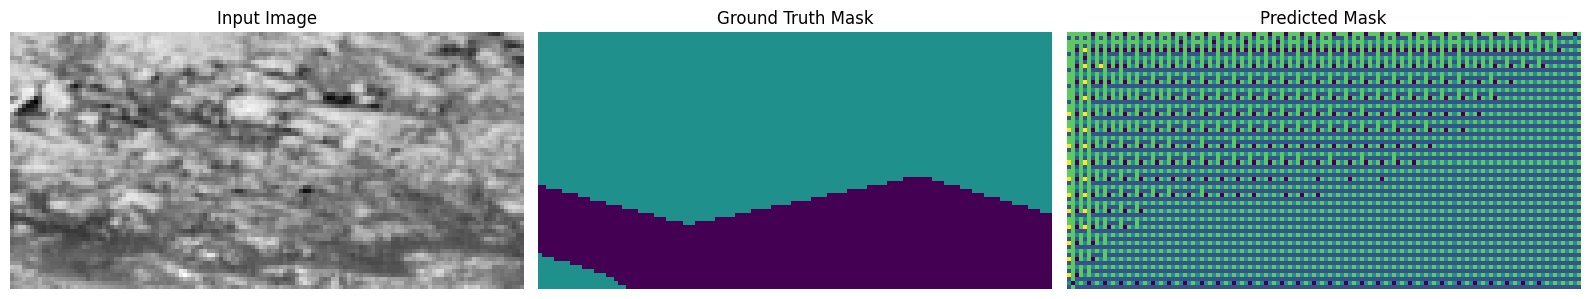

35/35 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.3325 - loss: 1.4907 - mean_iou: 0.1778 - val_accuracy: 0.2690 - val_loss: 10.6186 - val_mean_iou: 0.1180
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 687ms/step - accuracy: 0.4493 - loss: 1.2012 - mean_iou: 0.2586 - val_accuracy: 0.2196 - val_loss: 11.7244 - val_mean_iou: 0.0564
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 688ms/step - accuracy: 0.4760 - loss: 1.0638 - mean_iou: 0.2830 - val_accuracy: 0.1984 - val_loss: 11.6623 - val_mean_iou: 0.0532
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 712ms/step - accuracy: 0.5274 - loss: 0.8919 - mean_iou: 0.3276 - val_accuracy: 0.2171 - val_loss: 11.2433 - val_mean_iou: 0.0572
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 688ms/step - accuracy: 0.5071 - loss: 0.9020 - mean_iou: 0.3066 - val_accuracy: 0.2171 - val_loss: 11.0476 - val_mean_iou: 0.0715
Epoch 6/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.5447 - loss: 0.7869 - mean_iou: 0.3426

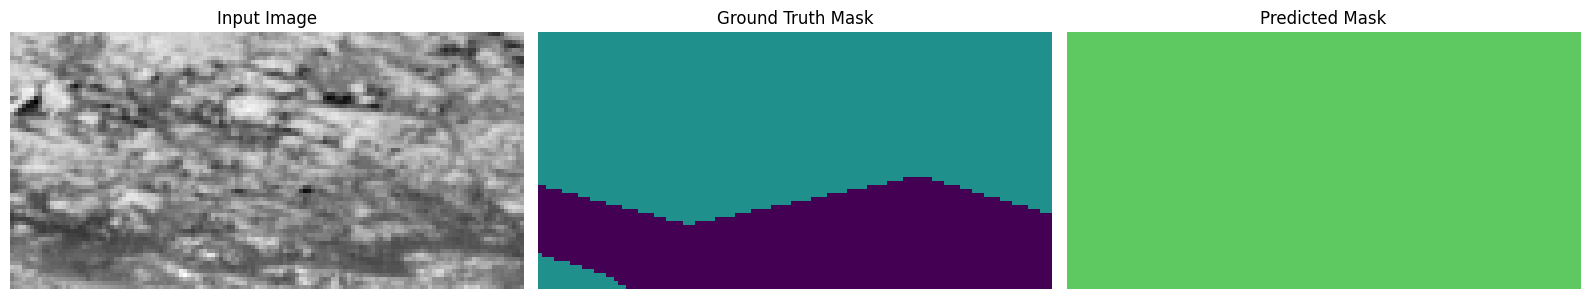

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 701ms/step - accuracy: 0.5447 - loss: 0.7870 - mean_iou: 0.3426 - val_accuracy: 0.2172 - val_loss: 5.9719 - val_mean_iou: 0.0715
Epoch 7/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 688ms/step - accuracy: 0.5698 - loss: 0.7068 - mean_iou: 0.3692 - val_accuracy: 0.2193 - val_loss: 6.4228 - val_mean_iou: 0.0734
Epoch 8/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 704ms/step - accuracy: 0.5619 - loss: 0.7254 - mean_iou: 0.3568 - val_accuracy: 0.3711 - val_loss: 2.3775 - val_mean_iou: 0.2069
Epoch 9/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 690ms/step - accuracy: 0.5658 - loss: 0.6950 - mean_iou: 0.3640 - val_accuracy: 0.4475 - val_loss: 1.6076 - val_mean_iou: 0.3137
Epoch 10/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 690ms/step - accuracy: 0.5812 - loss: 0.6514 - mean_iou: 0.3795 - val_accuracy: 0.4613 - val_loss: 1.6598 - val_mean_iou: 0.3217
Epoch 11/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.5766 - loss: 0.6420 - mean_iou: 0.3740

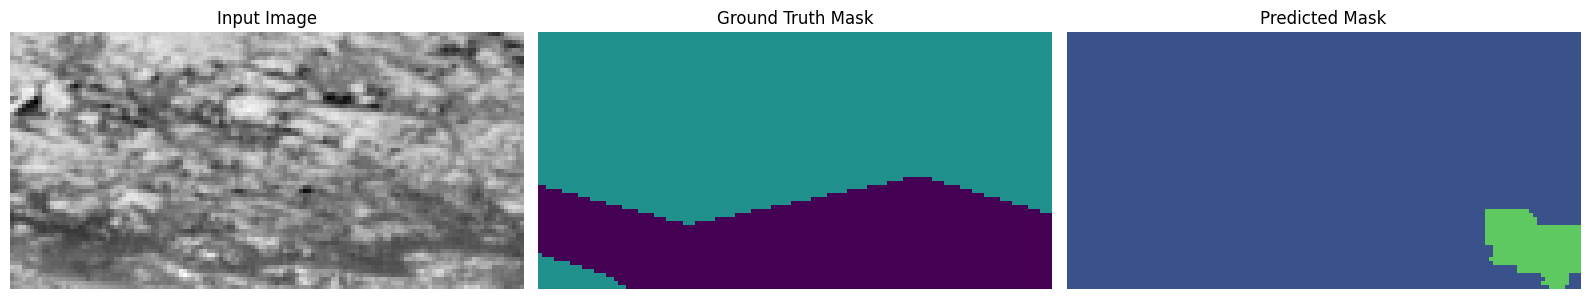

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 704ms/step - accuracy: 0.5769 - loss: 0.6417 - mean_iou: 0.3741 - val_accuracy: 0.4966 - val_loss: 1.1708 - val_mean_iou: 0.3458
Epoch 12/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 688ms/step - accuracy: 0.5891 - loss: 0.6061 - mean_iou: 0.3981 - val_accuracy: 0.5504 - val_loss: 0.8005 - val_mean_iou: 0.4141
Epoch 13/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 701ms/step - accuracy: 0.5898 - loss: 0.6028 - mean_iou: 0.3890 - val_accuracy: 0.5990 - val_loss: 0.6309 - val_mean_iou: 0.4784
Epoch 14/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 705ms/step - accuracy: 0.5857 - loss: 0.5997 - mean_iou: 0.3860 - val_accuracy: 0.5680 - val_loss: 0.7198 - val_mean_iou: 0.4460
Epoch 15/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 682ms/step - accuracy: 0.5961 - loss: 0.5721 - mean_iou: 0.3972 - val_accuracy: 0.5671 - val_loss: 0.7124 - val_mean_iou: 0.4434
Epoch 16/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.6114 - loss: 0.5459 - mean_iou: 0.4128

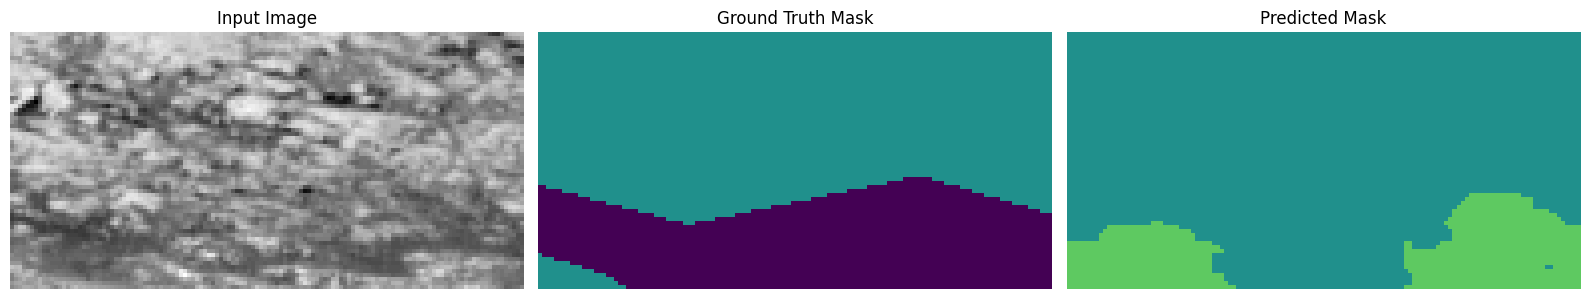

35/35 ━━━━━━━━━━━━━━━━━━━━ 43s 738ms/step - accuracy: 0.6113 - loss: 0.5463 - mean_iou: 0.4125 - val_accuracy: 0.6089 - val_loss: 0.5674 - val_mean_iou: 0.4944
Epoch 17/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 702ms/step - accuracy: 0.6012 - loss: 0.5575 - mean_iou: 0.4144 - val_accuracy: 0.6000 - val_loss: 0.5852 - val_mean_iou: 0.4811
Epoch 18/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 682ms/step - accuracy: 0.6136 - loss: 0.5297 - mean_iou: 0.4168 - val_accuracy: 0.5655 - val_loss: 0.6722 - val_mean_iou: 0.4520
Epoch 19/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 715ms/step - accuracy: 0.6080 - loss: 0.5329 - mean_iou: 0.4120 - val_accuracy: 0.5650 - val_loss: 0.6886 - val_mean_iou: 0.4500
Epoch 20/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 689ms/step - accuracy: 0.6094 - loss: 0.5238 - mean_iou: 0.4138 - val_accuracy: 0.4707 - val_loss: 1.0492 - val_mean_iou: 0.3531
Epoch 21/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.6232 - loss: 0.4969 - mean_iou: 0.4288

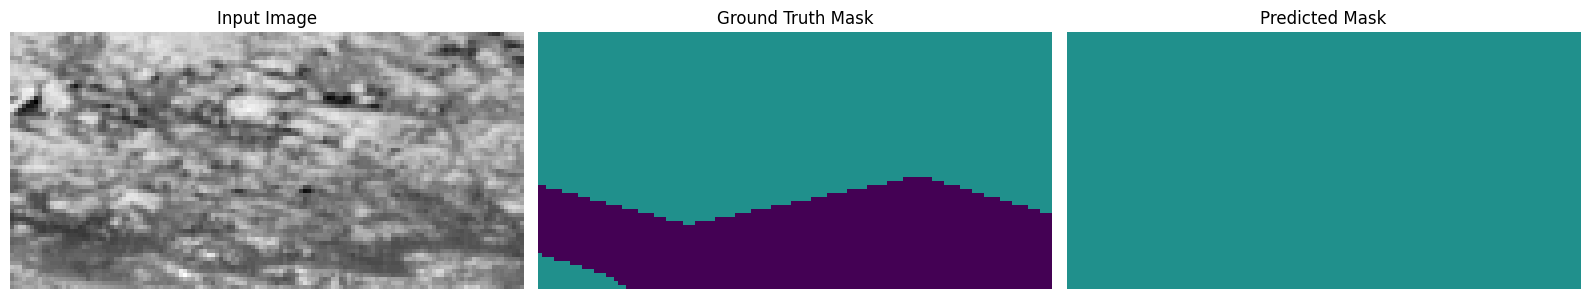

35/35 ━━━━━━━━━━━━━━━━━━━━ 43s 736ms/step - accuracy: 0.6232 - loss: 0.4975 - mean_iou: 0.4285 - val_accuracy: 0.5806 - val_loss: 0.7177 - val_mean_iou: 0.4685
Epoch 22/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 39s 692ms/step - accuracy: 0.6089 - loss: 0.5186 - mean_iou: 0.4120 - val_accuracy: 0.4264 - val_loss: 1.0573 - val_mean_iou: 0.2998
Epoch 23/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 695ms/step - accuracy: 0.6216 - loss: 0.4995 - mean_iou: 0.4262 - val_accuracy: 0.6173 - val_loss: 0.5048 - val_mean_iou: 0.5056
Epoch 24/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 708ms/step - accuracy: 0.6220 - loss: 0.4958 - mean_iou: 0.4238 - val_accuracy: 0.4334 - val_loss: 1.0514 - val_mean_iou: 0.3019
Epoch 25/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 687ms/step - accuracy: 0.6325 - loss: 0.4743 - mean_iou: 0.4445 - val_accuracy: 0.5388 - val_loss: 0.6983 - val_mean_iou: 0.4141
Epoch 26/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.6221 - loss: 0.5026 - mean_iou: 0.4338

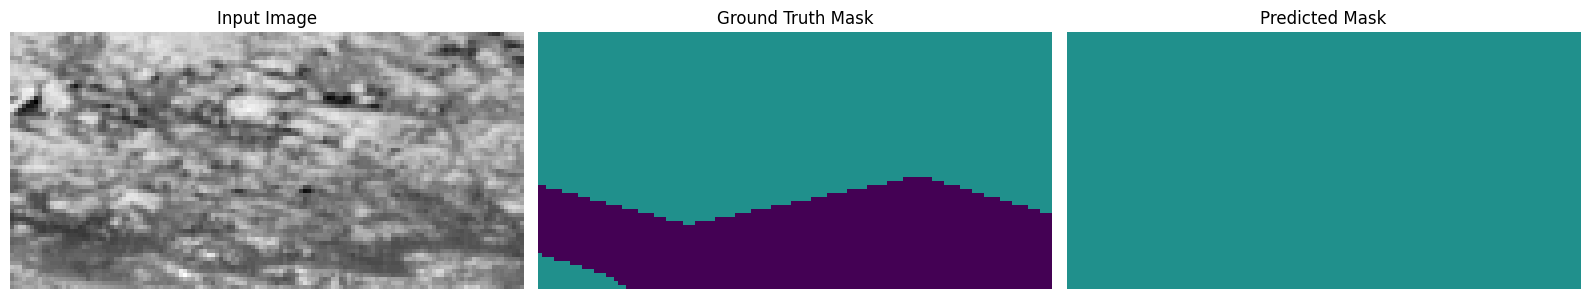

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 718ms/step - accuracy: 0.6221 - loss: 0.5027 - mean_iou: 0.4335 - val_accuracy: 0.6168 - val_loss: 0.5150 - val_mean_iou: 0.5141
Epoch 27/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 684ms/step - accuracy: 0.6300 - loss: 0.4784 - mean_iou: 0.4348 - val_accuracy: 0.6242 - val_loss: 0.5063 - val_mean_iou: 0.4092
Epoch 28/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 705ms/step - accuracy: 0.6318 - loss: 0.4675 - mean_iou: 0.4432 - val_accuracy: 0.5974 - val_loss: 0.5433 - val_mean_iou: 0.4740
Epoch 29/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 687ms/step - accuracy: 0.6306 - loss: 0.4698 - mean_iou: 0.4357 - val_accuracy: 0.6294 - val_loss: 0.5054 - val_mean_iou: 0.5256
Epoch 30/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 695ms/step - accuracy: 0.6363 - loss: 0.4658 - mean_iou: 0.4536 - val_accuracy: 0.6337 - val_loss: 0.4650 - val_mean_iou: 0.5302
Epoch 31/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.6402 - loss: 0.4557 - mean_iou: 0.4553

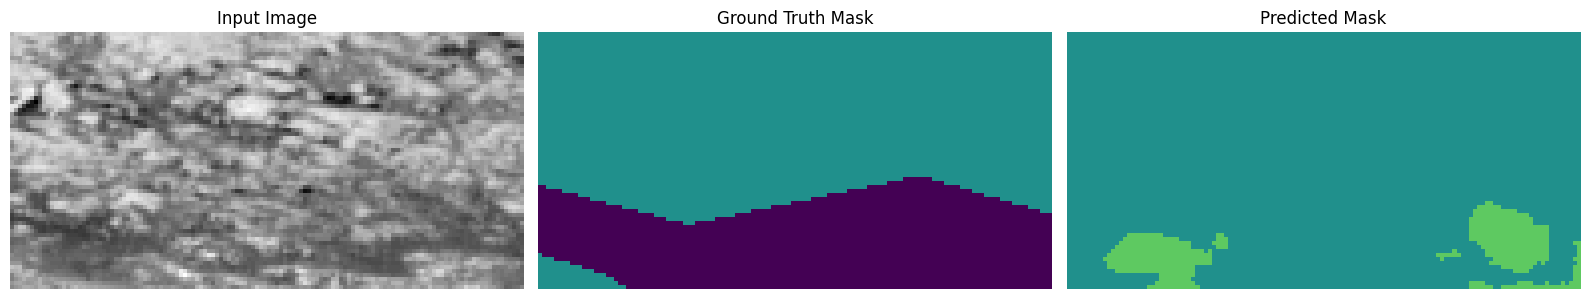

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 700ms/step - accuracy: 0.6403 - loss: 0.4559 - mean_iou: 0.4550 - val_accuracy: 0.6411 - val_loss: 0.4729 - val_mean_iou: 0.5447
Epoch 32/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 690ms/step - accuracy: 0.6438 - loss: 0.4409 - mean_iou: 0.4617 - val_accuracy: 0.5938 - val_loss: 0.5754 - val_mean_iou: 0.4863
Epoch 33/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 720ms/step - accuracy: 0.6327 - loss: 0.4574 - mean_iou: 0.4438 - val_accuracy: 0.5781 - val_loss: 0.6320 - val_mean_iou: 0.4627
Epoch 34/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 689ms/step - accuracy: 0.6290 - loss: 0.4627 - mean_iou: 0.4390 - val_accuracy: 0.4303 - val_loss: 1.0255 - val_mean_iou: 0.3039
Epoch 35/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 690ms/step - accuracy: 0.6373 - loss: 0.4486 - mean_iou: 0.4424 - val_accuracy: 0.4253 - val_loss: 1.1239 - val_mean_iou: 0.3000
Epoch 36/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.6446 - loss: 0.4400 - mean_iou: 0.4582

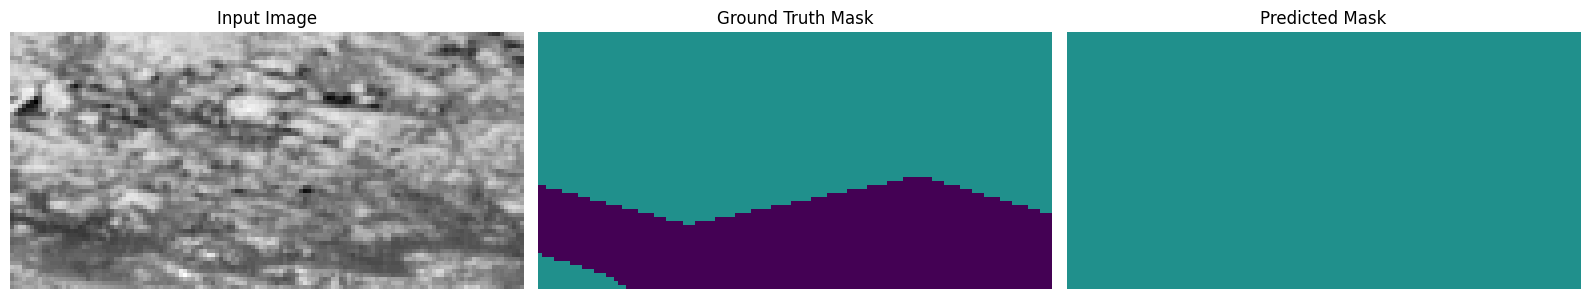

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 706ms/step - accuracy: 0.6446 - loss: 0.4404 - mean_iou: 0.4579 - val_accuracy: 0.6214 - val_loss: 0.5145 - val_mean_iou: 0.5231
Epoch 37/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 706ms/step - accuracy: 0.6416 - loss: 0.4361 - mean_iou: 0.4533 - val_accuracy: 0.6529 - val_loss: 0.4229 - val_mean_iou: 0.5604
Epoch 38/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 695ms/step - accuracy: 0.6449 - loss: 0.4347 - mean_iou: 0.4546 - val_accuracy: 0.5941 - val_loss: 0.6189 - val_mean_iou: 0.4842
Epoch 39/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 692ms/step - accuracy: 0.6387 - loss: 0.4449 - mean_iou: 0.4812 - val_accuracy: 0.5187 - val_loss: 0.7488 - val_mean_iou: 0.4033
Epoch 40/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 697ms/step - accuracy: 0.6441 - loss: 0.4297 - mean_iou: 0.4563 - val_accuracy: 0.5779 - val_loss: 0.6014 - val_mean_iou: 0.4734
Epoch 41/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.6587 - loss: 0.4009 - mean_iou: 0.4847

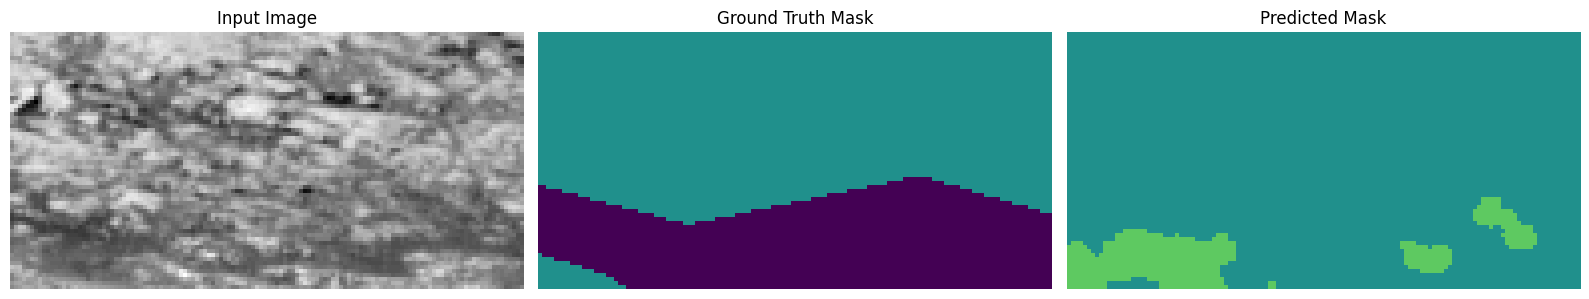

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 695ms/step - accuracy: 0.6586 - loss: 0.4015 - mean_iou: 0.4840 - val_accuracy: 0.6269 - val_loss: 0.4552 - val_mean_iou: 0.5319
Epoch 42/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 689ms/step - accuracy: 0.6569 - loss: 0.4069 - mean_iou: 0.5220 - val_accuracy: 0.6518 - val_loss: 0.4249 - val_mean_iou: 0.5563
Epoch 43/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 691ms/step - accuracy: 0.6590 - loss: 0.3968 - mean_iou: 0.5212 - val_accuracy: 0.6599 - val_loss: 0.3970 - val_mean_iou: 0.5693
Epoch 44/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 696ms/step - accuracy: 0.6459 - loss: 0.4237 - mean_iou: 0.4784 - val_accuracy: 0.5601 - val_loss: 0.6363 - val_mean_iou: 0.3562
Epoch 45/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 688ms/step - accuracy: 0.6534 - loss: 0.4121 - mean_iou: 0.4689 - val_accuracy: 0.6657 - val_loss: 0.3885 - val_mean_iou: 0.4660
Epoch 46/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.6519 - loss: 0.4173 - mean_iou: 0.4827

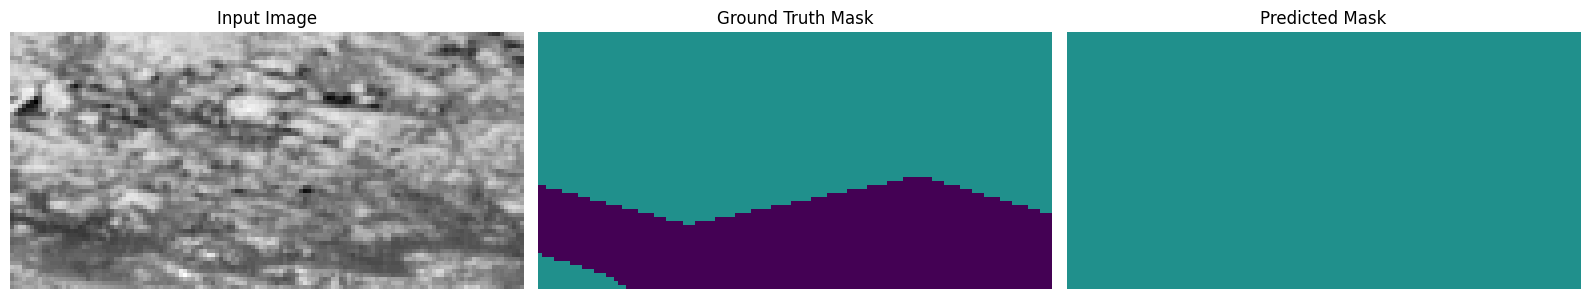

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 711ms/step - accuracy: 0.6520 - loss: 0.4175 - mean_iou: 0.4820 - val_accuracy: 0.6446 - val_loss: 0.4603 - val_mean_iou: 0.5462
Epoch 47/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 682ms/step - accuracy: 0.6470 - loss: 0.4156 - mean_iou: 0.4675 - val_accuracy: 0.6607 - val_loss: 0.4134 - val_mean_iou: 0.5690
Epoch 48/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 696ms/step - accuracy: 0.6593 - loss: 0.4019 - mean_iou: 0.4886 - val_accuracy: 0.6271 - val_loss: 0.5017 - val_mean_iou: 0.5169
Epoch 49/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 700ms/step - accuracy: 0.6607 - loss: 0.3921 - mean_iou: 0.4742 - val_accuracy: 0.5820 - val_loss: 0.6194 - val_mean_iou: 0.3789
Epoch 50/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 694ms/step - accuracy: 0.6532 - loss: 0.4081 - mean_iou: 0.4687 - val_accuracy: 0.6654 - val_loss: 0.3980 - val_mean_iou: 0.4653
Epoch 51/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.6548 - loss: 0.4042 - mean_iou: 0.4780

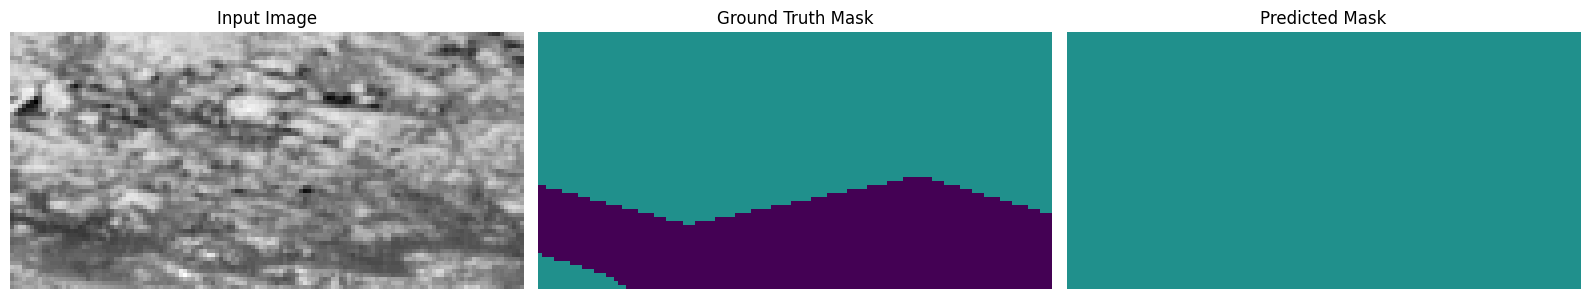

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 705ms/step - accuracy: 0.6550 - loss: 0.4042 - mean_iou: 0.4777 - val_accuracy: 0.6375 - val_loss: 0.4499 - val_mean_iou: 0.5370
Epoch 52/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 705ms/step - accuracy: 0.6631 - loss: 0.3842 - mean_iou: 0.5266 - val_accuracy: 0.5827 - val_loss: 0.5929 - val_mean_iou: 0.4805
Epoch 53/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 689ms/step - accuracy: 0.6535 - loss: 0.4101 - mean_iou: 0.4736 - val_accuracy: 0.5429 - val_loss: 0.6913 - val_mean_iou: 0.4274
Epoch 54/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 711ms/step - accuracy: 0.6551 - loss: 0.3980 - mean_iou: 0.5019 - val_accuracy: 0.6629 - val_loss: 0.4314 - val_mean_iou: 0.5763
Epoch 55/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 709ms/step - accuracy: 0.6556 - loss: 0.3971 - mean_iou: 0.4699 - val_accuracy: 0.6654 - val_loss: 0.4057 - val_mean_iou: 0.5835
Epoch 56/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.6660 - loss: 0.3786 - mean_iou: 0.5095

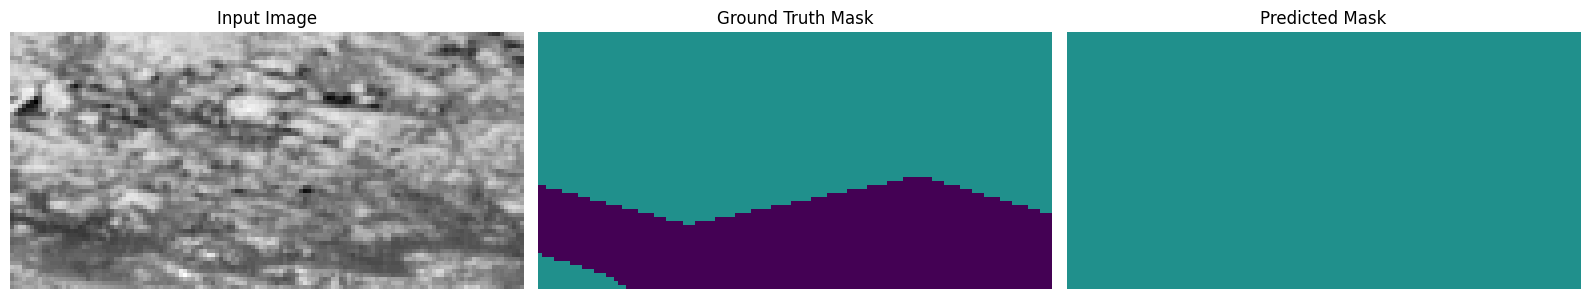

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 716ms/step - accuracy: 0.6660 - loss: 0.3791 - mean_iou: 0.5085 - val_accuracy: 0.6589 - val_loss: 0.3984 - val_mean_iou: 0.5723
Epoch 57/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 695ms/step - accuracy: 0.6649 - loss: 0.3835 - mean_iou: 0.4802 - val_accuracy: 0.6672 - val_loss: 0.3894 - val_mean_iou: 0.5830
Epoch 58/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 690ms/step - accuracy: 0.6571 - loss: 0.3837 - mean_iou: 0.4774 - val_accuracy: 0.6702 - val_loss: 0.3945 - val_mean_iou: 0.4694
Epoch 59/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 688ms/step - accuracy: 0.6626 - loss: 0.3847 - mean_iou: 0.4790 - val_accuracy: 0.5692 - val_loss: 0.6433 - val_mean_iou: 0.3692
Epoch 60/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 710ms/step - accuracy: 0.6701 - loss: 0.3707 - mean_iou: 0.4896 - val_accuracy: 0.6834 - val_loss: 0.3643 - val_mean_iou: 0.6087
Epoch 61/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.6586 - loss: 0.3957 - mean_iou: 0.5539

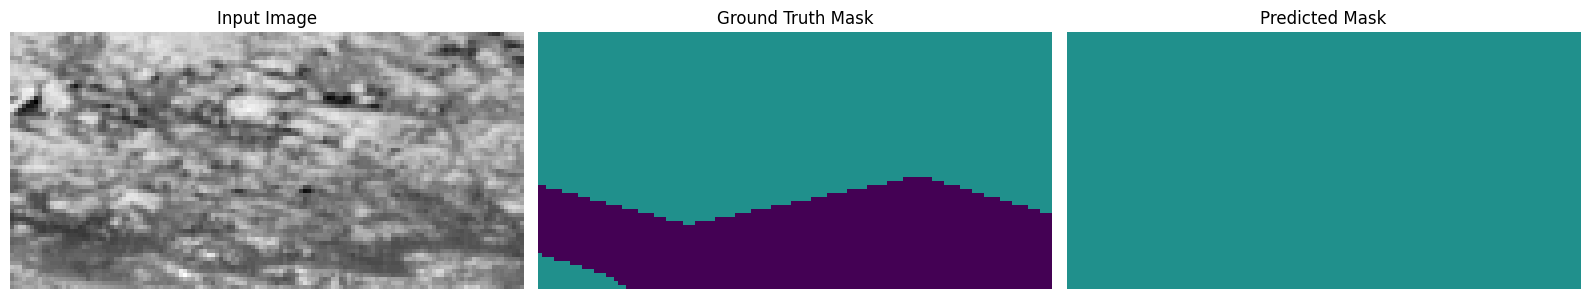

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 716ms/step - accuracy: 0.6588 - loss: 0.3958 - mean_iou: 0.5516 - val_accuracy: 0.6496 - val_loss: 0.4712 - val_mean_iou: 0.4422
Epoch 62/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 691ms/step - accuracy: 0.6569 - loss: 0.3974 - mean_iou: 0.4791 - val_accuracy: 0.5645 - val_loss: 0.6204 - val_mean_iou: 0.4550
Epoch 63/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 707ms/step - accuracy: 0.6644 - loss: 0.3771 - mean_iou: 0.5597 - val_accuracy: 0.6499 - val_loss: 0.4269 - val_mean_iou: 0.5562
Epoch 64/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 713ms/step - accuracy: 0.6716 - loss: 0.3655 - mean_iou: 0.4924 - val_accuracy: 0.6692 - val_loss: 0.4180 - val_mean_iou: 0.5854
Epoch 65/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 690ms/step - accuracy: 0.6629 - loss: 0.3831 - mean_iou: 0.5304 - val_accuracy: 0.6655 - val_loss: 0.4112 - val_mean_iou: 0.5792
Epoch 66/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.6688 - loss: 0.3817 - mean_iou: 0.5348

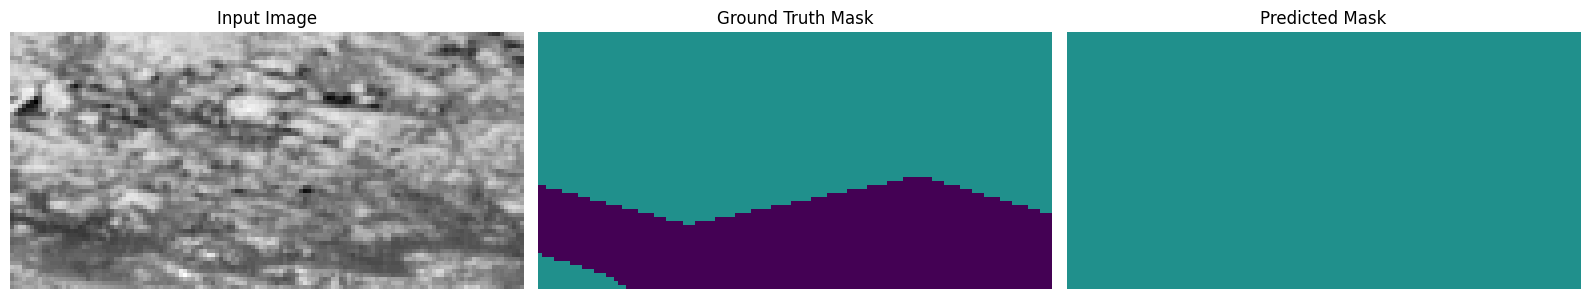

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 702ms/step - accuracy: 0.6687 - loss: 0.3822 - mean_iou: 0.5330 - val_accuracy: 0.6102 - val_loss: 0.5748 - val_mean_iou: 0.5001
Epoch 67/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 702ms/step - accuracy: 0.6680 - loss: 0.3748 - mean_iou: 0.4953 - val_accuracy: 0.6677 - val_loss: 0.3835 - val_mean_iou: 0.5835
Epoch 68/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 712ms/step - accuracy: 0.6731 - loss: 0.3656 - mean_iou: 0.5342 - val_accuracy: 0.6601 - val_loss: 0.3986 - val_mean_iou: 0.5729
Epoch 69/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 682ms/step - accuracy: 0.6764 - loss: 0.3542 - mean_iou: 0.5558 - val_accuracy: 0.6646 - val_loss: 0.4130 - val_mean_iou: 0.5791
Epoch 70/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 703ms/step - accuracy: 0.6652 - loss: 0.3701 - mean_iou: 0.4859 - val_accuracy: 0.6766 - val_loss: 0.3871 - val_mean_iou: 0.5989
Epoch 71/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.6698 - loss: 0.3739 - mean_iou: 0.5289

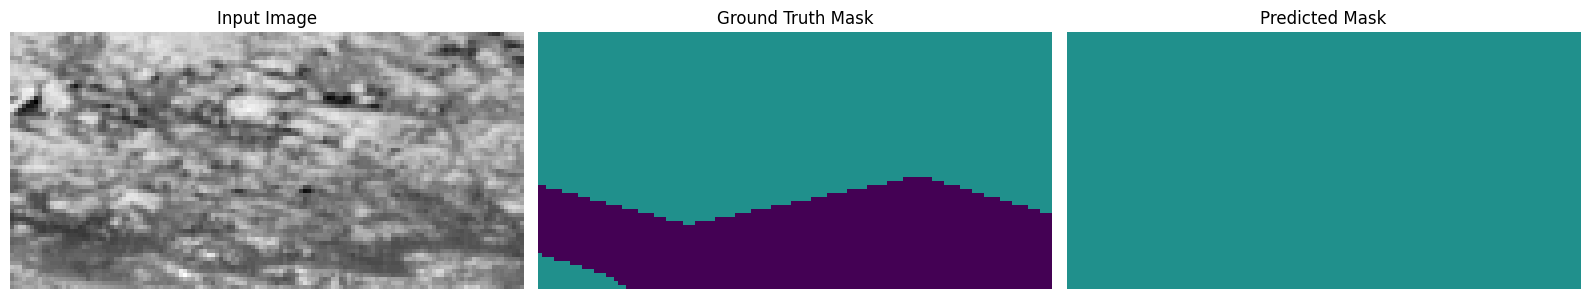

35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 723ms/step - accuracy: 0.6699 - loss: 0.3740 - mean_iou: 0.5277 - val_accuracy: 0.6491 - val_loss: 0.4721 - val_mean_iou: 0.5603
Epoch 72/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 706ms/step - accuracy: 0.6715 - loss: 0.3596 - mean_iou: 0.4916 - val_accuracy: 0.6645 - val_loss: 0.4024 - val_mean_iou: 0.5836
Epoch 73/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 694ms/step - accuracy: 0.6697 - loss: 0.3590 - mean_iou: 0.5601 - val_accuracy: 0.6574 - val_loss: 0.4147 - val_mean_iou: 0.5645
Epoch 74/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 690ms/step - accuracy: 0.6668 - loss: 0.3756 - mean_iou: 0.5056 - val_accuracy: 0.6601 - val_loss: 0.4185 - val_mean_iou: 0.5731
Epoch 75/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 709ms/step - accuracy: 0.6671 - loss: 0.3692 - mean_iou: 0.5130 - val_accuracy: 0.5786 - val_loss: 0.6083 - val_mean_iou: 0.4711
Epoch 76/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.6769 - loss: 0.3576 - mean_iou: 0.5027

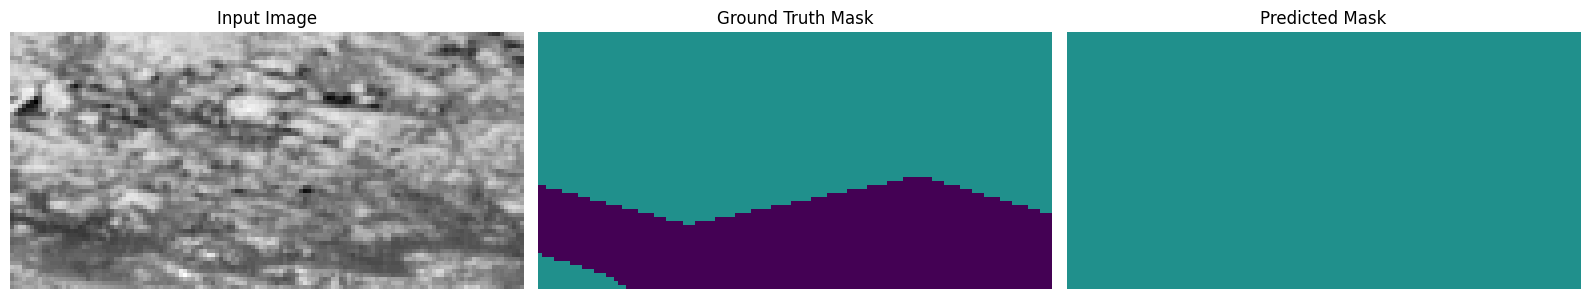

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 714ms/step - accuracy: 0.6769 - loss: 0.3578 - mean_iou: 0.5023 - val_accuracy: 0.6845 - val_loss: 0.3574 - val_mean_iou: 0.6081
Epoch 77/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 697ms/step - accuracy: 0.6779 - loss: 0.3440 - mean_iou: 0.5004 - val_accuracy: 0.6463 - val_loss: 0.4301 - val_mean_iou: 0.4473
Epoch 78/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 709ms/step - accuracy: 0.6665 - loss: 0.3697 - mean_iou: 0.5180 - val_accuracy: 0.6871 - val_loss: 0.3702 - val_mean_iou: 0.4921
Epoch 79/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 705ms/step - accuracy: 0.6721 - loss: 0.3519 - mean_iou: 0.5215 - val_accuracy: 0.6522 - val_loss: 0.4503 - val_mean_iou: 0.5670
Epoch 80/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 709ms/step - accuracy: 0.6732 - loss: 0.3619 - mean_iou: 0.5693 - val_accuracy: 0.6874 - val_loss: 0.3955 - val_mean_iou: 0.6143
Epoch 81/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.6792 - loss: 0.3478 - mean_iou: 0.6288

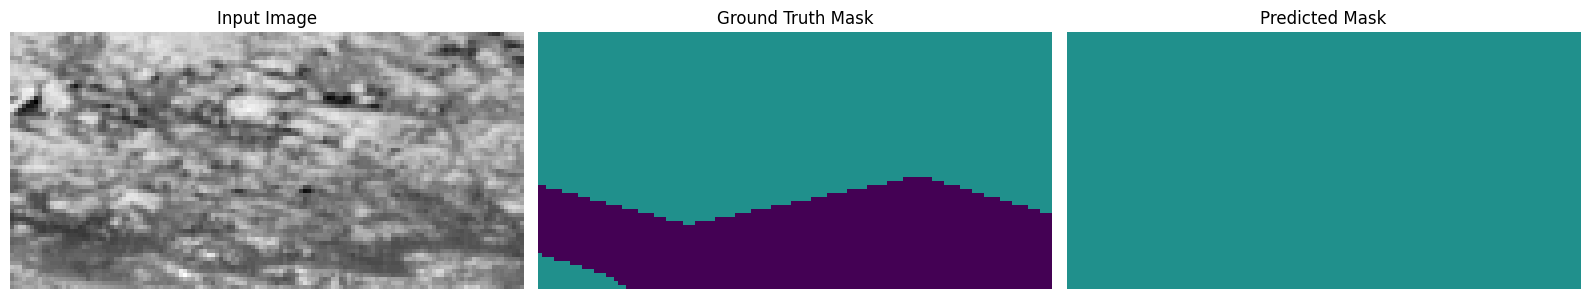

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 722ms/step - accuracy: 0.6791 - loss: 0.3483 - mean_iou: 0.6282 - val_accuracy: 0.6418 - val_loss: 0.4442 - val_mean_iou: 0.5494
Epoch 82/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 688ms/step - accuracy: 0.6774 - loss: 0.3492 - mean_iou: 0.5776 - val_accuracy: 0.6576 - val_loss: 0.4409 - val_mean_iou: 0.5747
Epoch 83/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 686ms/step - accuracy: 0.6759 - loss: 0.3505 - mean_iou: 0.5547 - val_accuracy: 0.6823 - val_loss: 0.3556 - val_mean_iou: 0.6054
Epoch 84/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 715ms/step - accuracy: 0.6804 - loss: 0.3491 - mean_iou: 0.5523 - val_accuracy: 0.6712 - val_loss: 0.3827 - val_mean_iou: 0.4756
Epoch 85/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 708ms/step - accuracy: 0.6717 - loss: 0.3575 - mean_iou: 0.5077 - val_accuracy: 0.6927 - val_loss: 0.3533 - val_mean_iou: 0.6242
Epoch 86/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.6821 - loss: 0.3409 - mean_iou: 0.6288

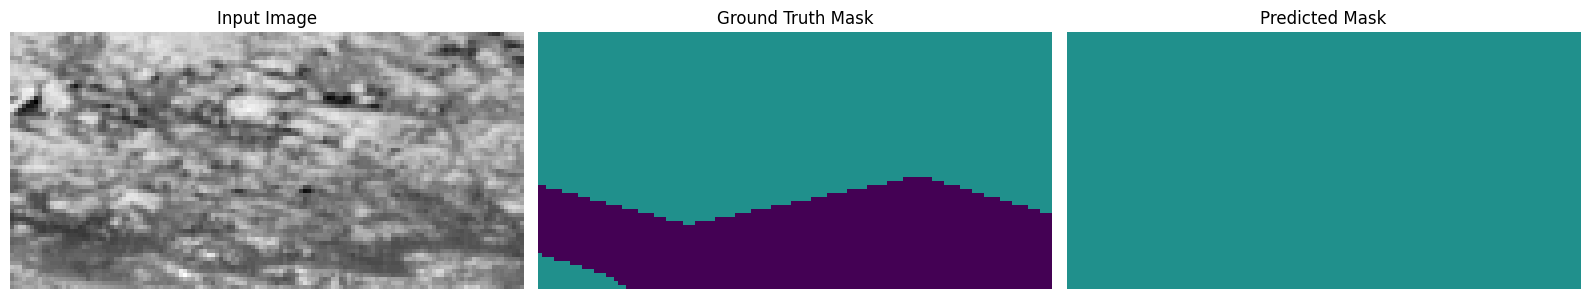

35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 696ms/step - accuracy: 0.6822 - loss: 0.3412 - mean_iou: 0.6287 - val_accuracy: 0.6796 - val_loss: 0.3460 - val_mean_iou: 0.6019
Epoch 87/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 693ms/step - accuracy: 0.6784 - loss: 0.3497 - mean_iou: 0.5677 - val_accuracy: 0.6538 - val_loss: 0.4193 - val_mean_iou: 0.5643
Epoch 88/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 712ms/step - accuracy: 0.6724 - loss: 0.3661 - mean_iou: 0.4885 - val_accuracy: 0.6687 - val_loss: 0.3959 - val_mean_iou: 0.5874
Epoch 89/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 681ms/step - accuracy: 0.6769 - loss: 0.3515 - mean_iou: 0.5121 - val_accuracy: 0.6782 - val_loss: 0.3705 - val_mean_iou: 0.6072
Epoch 90/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 687ms/step - accuracy: 0.6793 - loss: 0.3514 - mean_iou: 0.5169 - val_accuracy: 0.6913 - val_loss: 0.3441 - val_mean_iou: 0.6231
Epoch 91/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.6818 - loss: 0.3527 - mean_iou: 0.5681

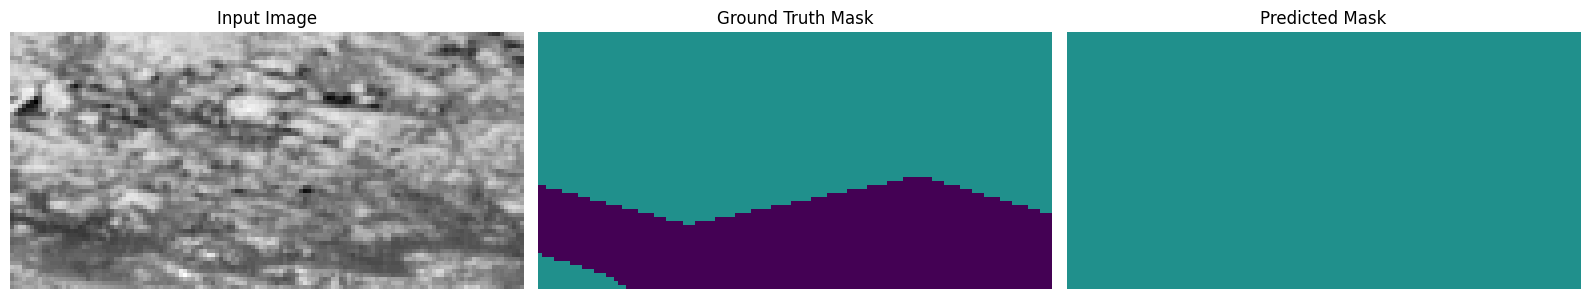

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 706ms/step - accuracy: 0.6819 - loss: 0.3526 - mean_iou: 0.5665 - val_accuracy: 0.6842 - val_loss: 0.3513 - val_mean_iou: 0.6135
Epoch 92/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 712ms/step - accuracy: 0.6778 - loss: 0.3510 - mean_iou: 0.5718 - val_accuracy: 0.5986 - val_loss: 0.5485 - val_mean_iou: 0.4947
Epoch 93/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 689ms/step - accuracy: 0.6708 - loss: 0.3554 - mean_iou: 0.6125 - val_accuracy: 0.6750 - val_loss: 0.3772 - val_mean_iou: 0.5990
Epoch 94/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 697ms/step - accuracy: 0.6842 - loss: 0.3295 - mean_iou: 0.5334 - val_accuracy: 0.6832 - val_loss: 0.3659 - val_mean_iou: 0.6057
Epoch 95/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 684ms/step - accuracy: 0.6786 - loss: 0.3451 - mean_iou: 0.5015 - val_accuracy: 0.6904 - val_loss: 0.3443 - val_mean_iou: 0.6217
Epoch 96/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.6812 - loss: 0.3392 - mean_iou: 0.5539

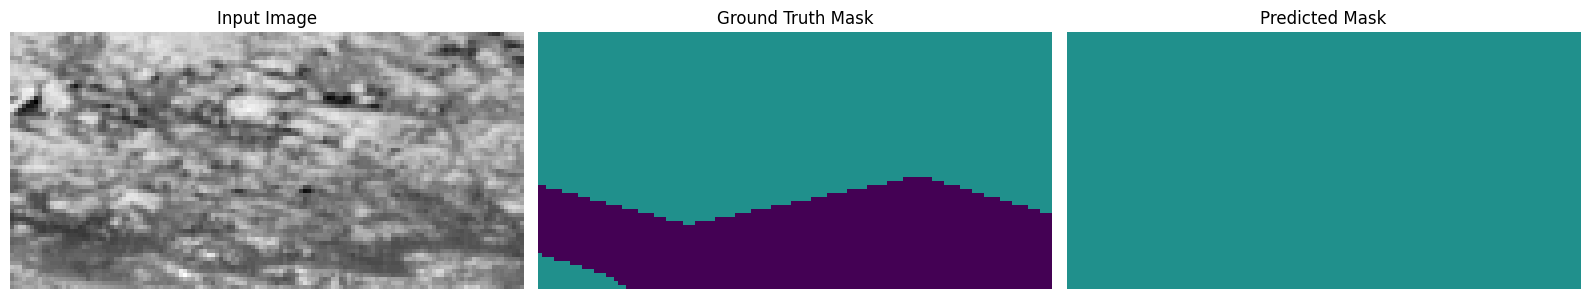

35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 711ms/step - accuracy: 0.6814 - loss: 0.3392 - mean_iou: 0.5524 - val_accuracy: 0.6775 - val_loss: 0.3807 - val_mean_iou: 0.5982
Epoch 97/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 704ms/step - accuracy: 0.6837 - loss: 0.3394 - mean_iou: 0.6296 - val_accuracy: 0.6765 - val_loss: 0.3598 - val_mean_iou: 0.5962
Epoch 98/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 707ms/step - accuracy: 0.6721 - loss: 0.3510 - mean_iou: 0.6143 - val_accuracy: 0.6872 - val_loss: 0.3589 - val_mean_iou: 0.6200
Epoch 99/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 705ms/step - accuracy: 0.6837 - loss: 0.3364 - mean_iou: 0.5174 - val_accuracy: 0.6693 - val_loss: 0.3979 - val_mean_iou: 0.5867
Epoch 100/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 704ms/step - accuracy: 0.6834 - loss: 0.3344 - mean_iou: 0.6293 - val_accuracy: 0.6797 - val_loss: 0.3695 - val_mean_iou: 0.5978
Epoch 101/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.6804 - loss: 0.3309 - mean_iou: 0.6396

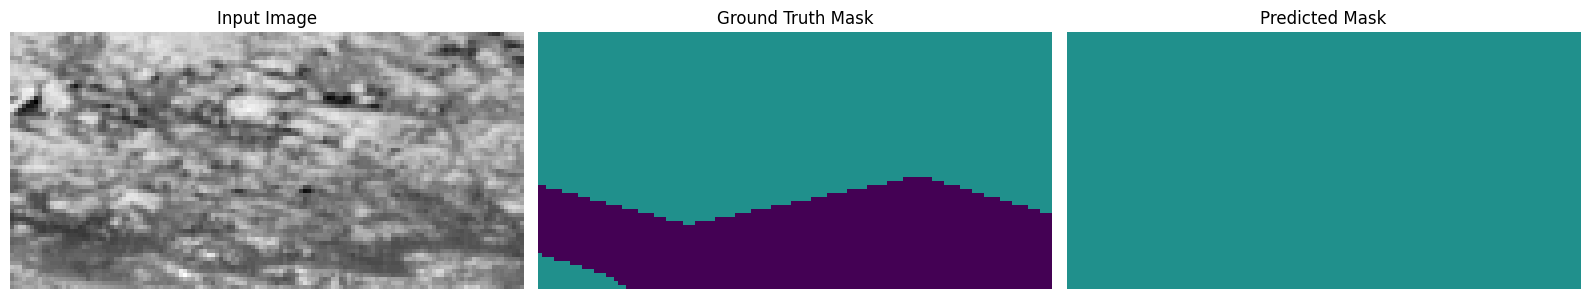

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 720ms/step - accuracy: 0.6807 - loss: 0.3311 - mean_iou: 0.6396 - val_accuracy: 0.6902 - val_loss: 0.3514 - val_mean_iou: 0.6203
Epoch 102/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 698ms/step - accuracy: 0.6877 - loss: 0.3251 - mean_iou: 0.6466 - val_accuracy: 0.6741 - val_loss: 0.3877 - val_mean_iou: 0.6002
Epoch 103/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 703ms/step - accuracy: 0.6725 - loss: 0.3541 - mean_iou: 0.5872 - val_accuracy: 0.6803 - val_loss: 0.3847 - val_mean_iou: 0.6060
Epoch 104/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 707ms/step - accuracy: 0.6849 - loss: 0.3273 - mean_iou: 0.6085 - val_accuracy: 0.6885 - val_loss: 0.3470 - val_mean_iou: 0.6180
Epoch 105/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 712ms/step - accuracy: 0.6856 - loss: 0.3321 - mean_iou: 0.5360 - val_accuracy: 0.6836 - val_loss: 0.3718 - val_mean_iou: 0.6073
Epoch 106/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.6864 - loss: 0.3255 - mean_iou: 0.6388

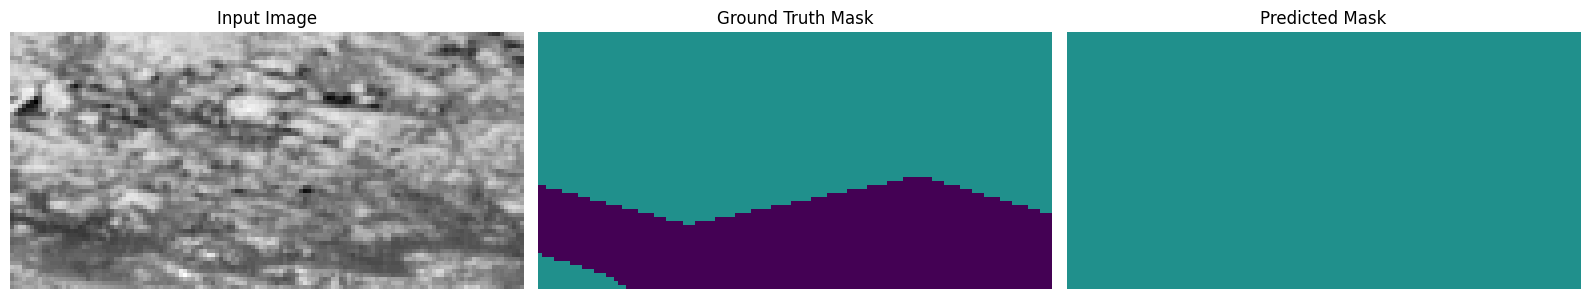

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 706ms/step - accuracy: 0.6867 - loss: 0.3257 - mean_iou: 0.6387 - val_accuracy: 0.6908 - val_loss: 0.3486 - val_mean_iou: 0.6193
Epoch 107/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 710ms/step - accuracy: 0.6819 - loss: 0.3316 - mean_iou: 0.5358 - val_accuracy: 0.6927 - val_loss: 0.3511 - val_mean_iou: 0.6289
Epoch 108/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 709ms/step - accuracy: 0.6793 - loss: 0.3389 - mean_iou: 0.6239 - val_accuracy: 0.6848 - val_loss: 0.3751 - val_mean_iou: 0.6085
Epoch 109/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 697ms/step - accuracy: 0.6837 - loss: 0.3356 - mean_iou: 0.6324 - val_accuracy: 0.6796 - val_loss: 0.3817 - val_mean_iou: 0.6083
Epoch 110/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 689ms/step - accuracy: 0.6821 - loss: 0.3338 - mean_iou: 0.5160 - val_accuracy: 0.6720 - val_loss: 0.3939 - val_mean_iou: 0.5885
Epoch 111/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.6867 - loss: 0.3255 - mean_iou: 0.5651

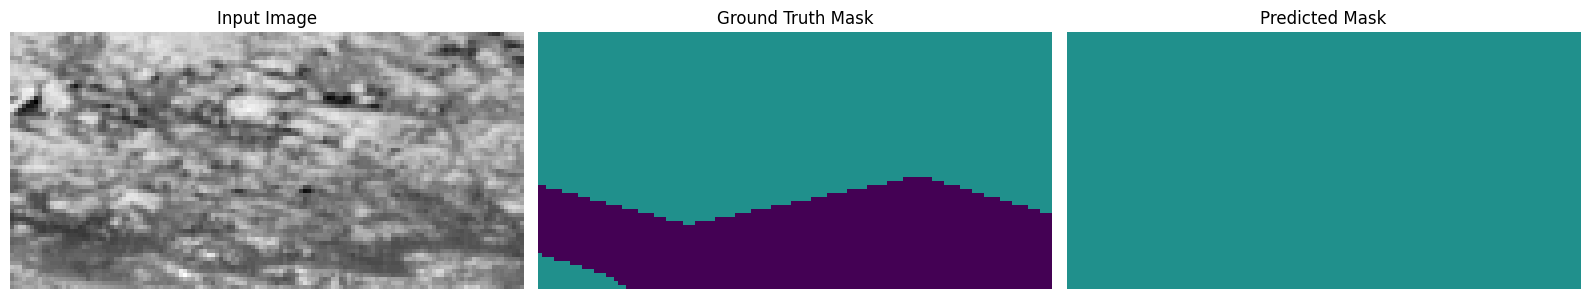

35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 727ms/step - accuracy: 0.6869 - loss: 0.3256 - mean_iou: 0.5638 - val_accuracy: 0.6802 - val_loss: 0.3733 - val_mean_iou: 0.6029
Epoch 112/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 706ms/step - accuracy: 0.6887 - loss: 0.3258 - mean_iou: 0.6426 - val_accuracy: 0.6889 - val_loss: 0.3618 - val_mean_iou: 0.6175
Epoch 113/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 709ms/step - accuracy: 0.6940 - loss: 0.3209 - mean_iou: 0.5843 - val_accuracy: 0.6846 - val_loss: 0.3495 - val_mean_iou: 0.4870
Epoch 114/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 703ms/step - accuracy: 0.6891 - loss: 0.3235 - mean_iou: 0.6460 - val_accuracy: 0.6896 - val_loss: 0.3534 - val_mean_iou: 0.6210
Epoch 115/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 715ms/step - accuracy: 0.6867 - loss: 0.3261 - mean_iou: 0.5866 - val_accuracy: 0.6854 - val_loss: 0.3649 - val_mean_iou: 0.6149
Epoch 116/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.6811 - loss: 0.3306 - mean_iou: 0.5189

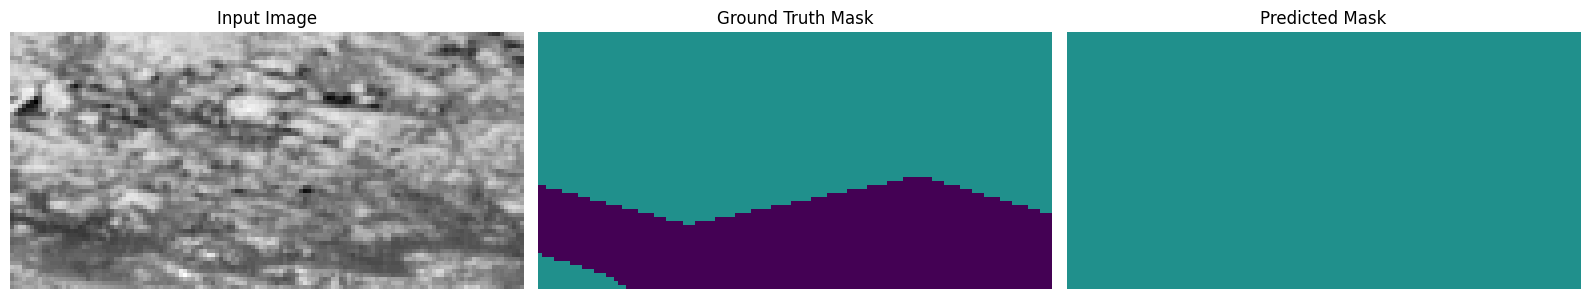

35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 699ms/step - accuracy: 0.6815 - loss: 0.3306 - mean_iou: 0.5188 - val_accuracy: 0.6731 - val_loss: 0.3773 - val_mean_iou: 0.5899
Epoch 117/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 716ms/step - accuracy: 0.6876 - loss: 0.3238 - mean_iou: 0.5608 - val_accuracy: 0.6796 - val_loss: 0.3744 - val_mean_iou: 0.6012
Epoch 118/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 707ms/step - accuracy: 0.6948 - loss: 0.3096 - mean_iou: 0.6189 - val_accuracy: 0.6710 - val_loss: 0.3996 - val_mean_iou: 0.5870
Epoch 119/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 712ms/step - accuracy: 0.6819 - loss: 0.3300 - mean_iou: 0.6073 - val_accuracy: 0.6564 - val_loss: 0.4148 - val_mean_iou: 0.5638
Epoch 120/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 700ms/step - accuracy: 0.6866 - loss: 0.3296 - mean_iou: 0.5186 - val_accuracy: 0.6895 - val_loss: 0.3547 - val_mean_iou: 0.6196
Epoch 121/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.6786 - loss: 0.3292 - mean_iou: 0.5236

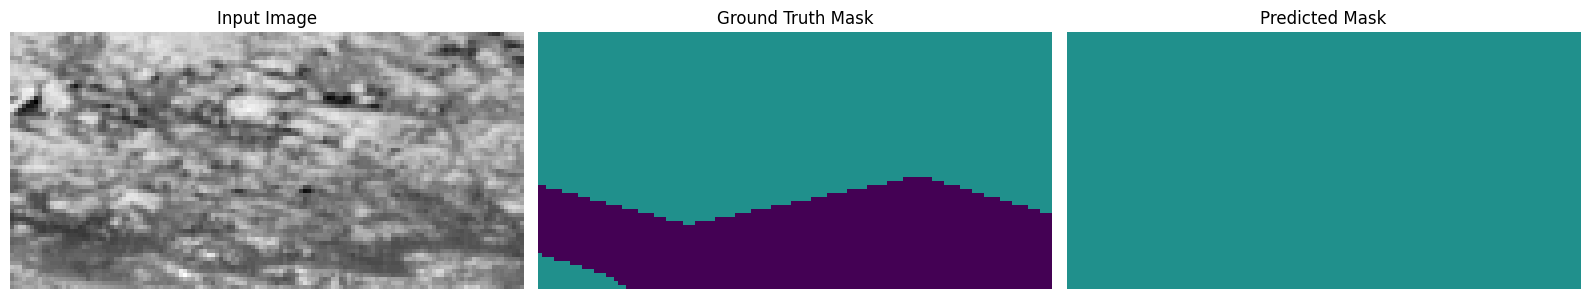

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 725ms/step - accuracy: 0.6790 - loss: 0.3290 - mean_iou: 0.5235 - val_accuracy: 0.6863 - val_loss: 0.3509 - val_mean_iou: 0.6152
Epoch 122/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 693ms/step - accuracy: 0.6795 - loss: 0.3343 - mean_iou: 0.5267 - val_accuracy: 0.6975 - val_loss: 0.3392 - val_mean_iou: 0.6334
Epoch 123/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 719ms/step - accuracy: 0.6862 - loss: 0.3206 - mean_iou: 0.5298 - val_accuracy: 0.6711 - val_loss: 0.3784 - val_mean_iou: 0.5883
Epoch 124/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 707ms/step - accuracy: 0.6852 - loss: 0.3478 - mean_iou: 0.5219 - val_accuracy: 0.6778 - val_loss: 0.3626 - val_mean_iou: 0.5980
Epoch 125/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 693ms/step - accuracy: 0.6866 - loss: 0.3275 - mean_iou: 0.5138 - val_accuracy: 0.6957 - val_loss: 0.3412 - val_mean_iou: 0.6300
Epoch 126/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.6950 - loss: 0.3145 - mean_iou: 0.5268

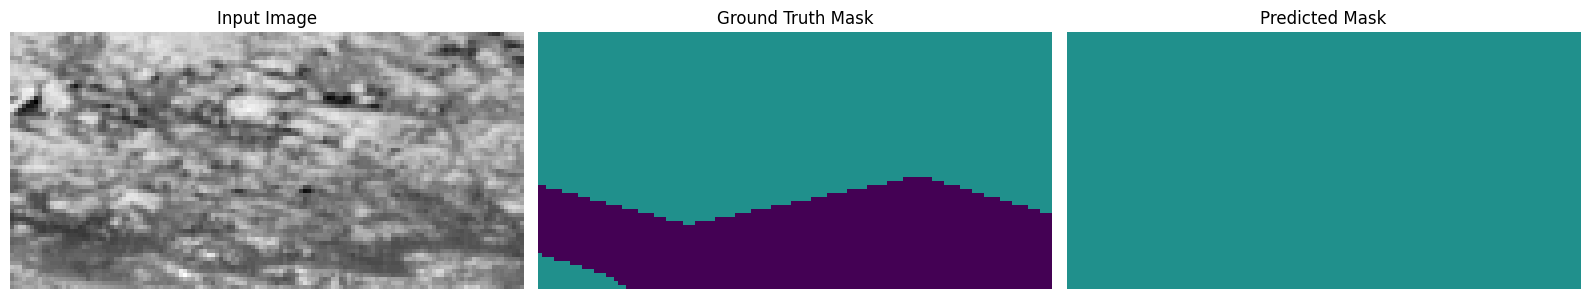

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 699ms/step - accuracy: 0.6952 - loss: 0.3146 - mean_iou: 0.5266 - val_accuracy: 0.6878 - val_loss: 0.3541 - val_mean_iou: 0.6192
Epoch 127/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 693ms/step - accuracy: 0.6893 - loss: 0.3189 - mean_iou: 0.5299 - val_accuracy: 0.6889 - val_loss: 0.3509 - val_mean_iou: 0.6173
Epoch 128/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 692ms/step - accuracy: 0.6968 - loss: 0.3059 - mean_iou: 0.5387 - val_accuracy: 0.6904 - val_loss: 0.3350 - val_mean_iou: 0.6193
Epoch 129/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 712ms/step - accuracy: 0.6963 - loss: 0.3083 - mean_iou: 0.5314 - val_accuracy: 0.6993 - val_loss: 0.3419 - val_mean_iou: 0.6349
Epoch 130/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 690ms/step - accuracy: 0.6913 - loss: 0.3127 - mean_iou: 0.5303 - val_accuracy: 0.6851 - val_loss: 0.3588 - val_mean_iou: 0.6167
Epoch 131/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.6881 - loss: 0.3178 - mean_iou: 0.5471

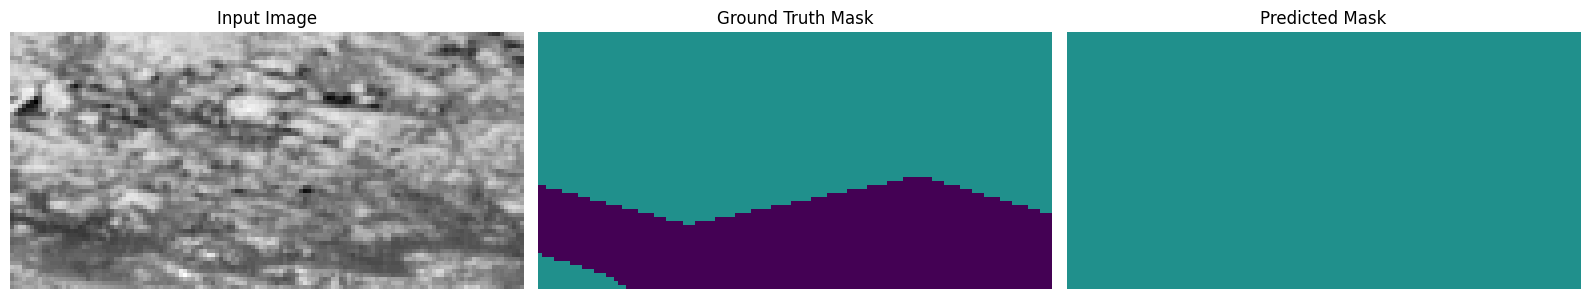

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 719ms/step - accuracy: 0.6885 - loss: 0.3178 - mean_iou: 0.5465 - val_accuracy: 0.6731 - val_loss: 0.3817 - val_mean_iou: 0.4720
Epoch 132/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 700ms/step - accuracy: 0.6982 - loss: 0.3113 - mean_iou: 0.5289 - val_accuracy: 0.6927 - val_loss: 0.3251 - val_mean_iou: 0.6320
Epoch 133/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 699ms/step - accuracy: 0.6926 - loss: 0.3178 - mean_iou: 0.5333 - val_accuracy: 0.6821 - val_loss: 0.3624 - val_mean_iou: 0.4856
Epoch 134/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 685ms/step - accuracy: 0.6981 - loss: 0.3026 - mean_iou: 0.5443 - val_accuracy: 0.6871 - val_loss: 0.3506 - val_mean_iou: 0.6174
Epoch 135/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 688ms/step - accuracy: 0.6994 - loss: 0.3028 - mean_iou: 0.5516 - val_accuracy: 0.6955 - val_loss: 0.3422 - val_mean_iou: 0.5045
Epoch 136/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.6897 - loss: 0.3146 - mean_iou: 0.5256

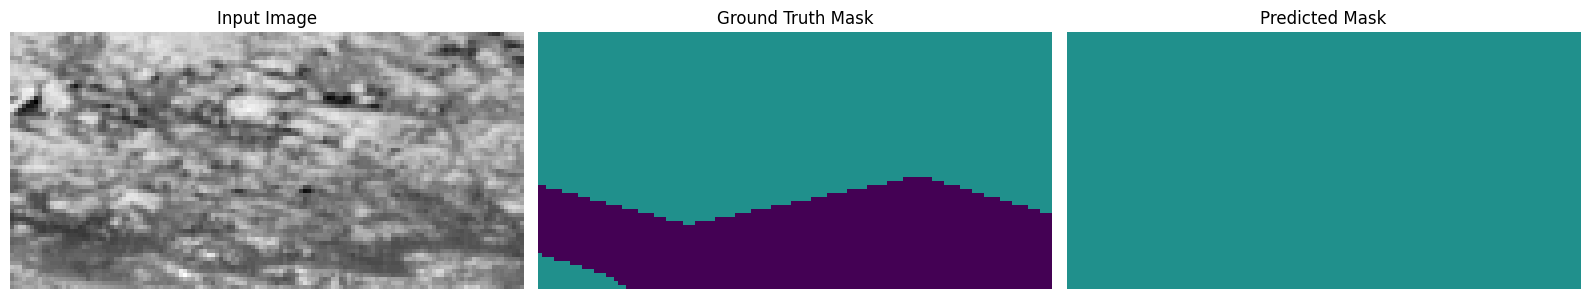

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 700ms/step - accuracy: 0.6901 - loss: 0.3145 - mean_iou: 0.5255 - val_accuracy: 0.6065 - val_loss: 0.5290 - val_mean_iou: 0.4111
Epoch 137/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 708ms/step - accuracy: 0.6917 - loss: 0.3218 - mean_iou: 0.5377 - val_accuracy: 0.6926 - val_loss: 0.3354 - val_mean_iou: 0.4993
Epoch 138/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 691ms/step - accuracy: 0.7049 - loss: 0.2932 - mean_iou: 0.5622 - val_accuracy: 0.6919 - val_loss: 0.3460 - val_mean_iou: 0.5010
Epoch 139/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 696ms/step - accuracy: 0.6909 - loss: 0.3145 - mean_iou: 0.5345 - val_accuracy: 0.6852 - val_loss: 0.3582 - val_mean_iou: 0.4938
Epoch 140/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 696ms/step - accuracy: 0.7041 - loss: 0.2975 - mean_iou: 0.5421 - val_accuracy: 0.6994 - val_loss: 0.3189 - val_mean_iou: 0.5200
Epoch 141/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.6934 - loss: 0.3168 - mean_iou: 0.5276

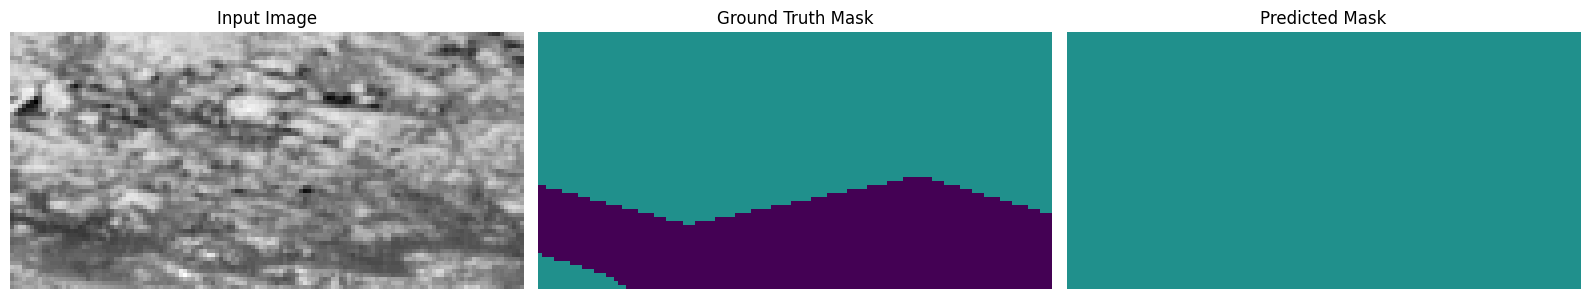

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 690ms/step - accuracy: 0.6937 - loss: 0.3168 - mean_iou: 0.5275 - val_accuracy: 0.7007 - val_loss: 0.3245 - val_mean_iou: 0.5157
Epoch 142/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 697ms/step - accuracy: 0.7007 - loss: 0.2991 - mean_iou: 0.5585 - val_accuracy: 0.7006 - val_loss: 0.3285 - val_mean_iou: 0.6440
Epoch 143/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 688ms/step - accuracy: 0.7021 - loss: 0.2935 - mean_iou: 0.5563 - val_accuracy: 0.6900 - val_loss: 0.3406 - val_mean_iou: 0.6220
Epoch 144/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 685ms/step - accuracy: 0.7010 - loss: 0.2995 - mean_iou: 0.5618 - val_accuracy: 0.6990 - val_loss: 0.3304 - val_mean_iou: 0.6376
Epoch 145/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 698ms/step - accuracy: 0.6990 - loss: 0.2938 - mean_iou: 0.5580 - val_accuracy: 0.7027 - val_loss: 0.3346 - val_mean_iou: 0.6501
Epoch 146/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.6988 - loss: 0.3070 - mean_iou: 0.5467

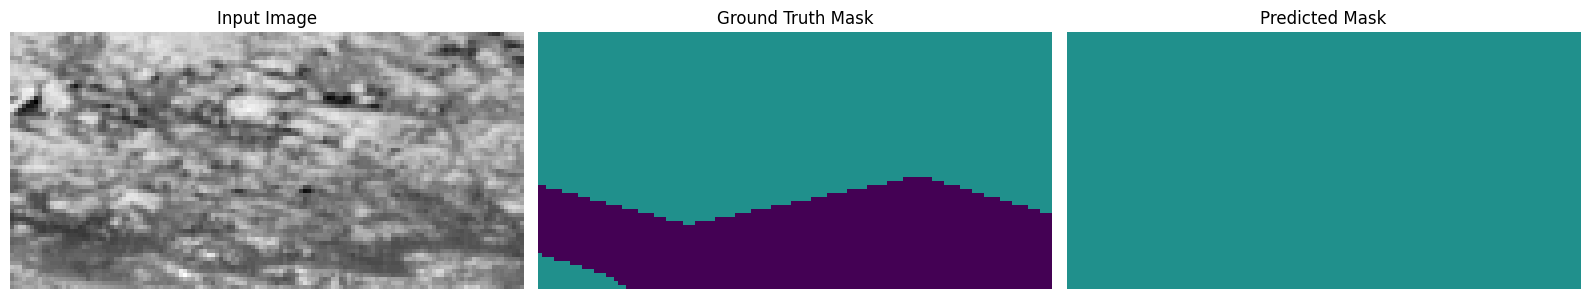

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 694ms/step - accuracy: 0.6990 - loss: 0.3070 - mean_iou: 0.5467 - val_accuracy: 0.6989 - val_loss: 0.3343 - val_mean_iou: 0.6428
Epoch 147/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 710ms/step - accuracy: 0.6958 - loss: 0.3023 - mean_iou: 0.5496 - val_accuracy: 0.6799 - val_loss: 0.3606 - val_mean_iou: 0.4819
Epoch 148/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 714ms/step - accuracy: 0.6922 - loss: 0.3152 - mean_iou: 0.5444 - val_accuracy: 0.7069 - val_loss: 0.3216 - val_mean_iou: 0.6564
Epoch 149/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 711ms/step - accuracy: 0.7003 - loss: 0.2960 - mean_iou: 0.5640 - val_accuracy: 0.7017 - val_loss: 0.3234 - val_mean_iou: 0.6478
Epoch 150/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 685ms/step - accuracy: 0.6987 - loss: 0.2888 - mean_iou: 0.5631 - val_accuracy: 0.7024 - val_loss: 0.3292 - val_mean_iou: 0.6442
Epoch 151/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.6952 - loss: 0.3053 - mean_iou: 0.5296

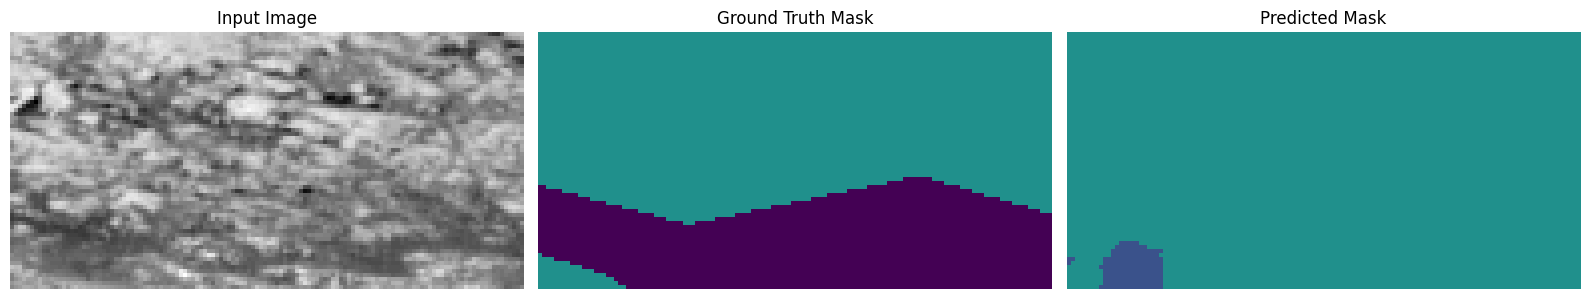

35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 721ms/step - accuracy: 0.6953 - loss: 0.3055 - mean_iou: 0.5295 - val_accuracy: 0.6788 - val_loss: 0.3885 - val_mean_iou: 0.6057
Epoch 152/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 709ms/step - accuracy: 0.6937 - loss: 0.3083 - mean_iou: 0.5327 - val_accuracy: 0.6979 - val_loss: 0.3423 - val_mean_iou: 0.6450
Epoch 153/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 691ms/step - accuracy: 0.6989 - loss: 0.3021 - mean_iou: 0.5707 - val_accuracy: 0.6992 - val_loss: 0.3231 - val_mean_iou: 0.6404
Epoch 154/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 689ms/step - accuracy: 0.6973 - loss: 0.3000 - mean_iou: 0.5555 - val_accuracy: 0.6960 - val_loss: 0.3367 - val_mean_iou: 0.6472
Epoch 155/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 680ms/step - accuracy: 0.6972 - loss: 0.3010 - mean_iou: 0.5554 - val_accuracy: 0.7013 - val_loss: 0.3418 - val_mean_iou: 0.6442
Epoch 156/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.6976 - loss: 0.2961 - mean_iou: 0.5585

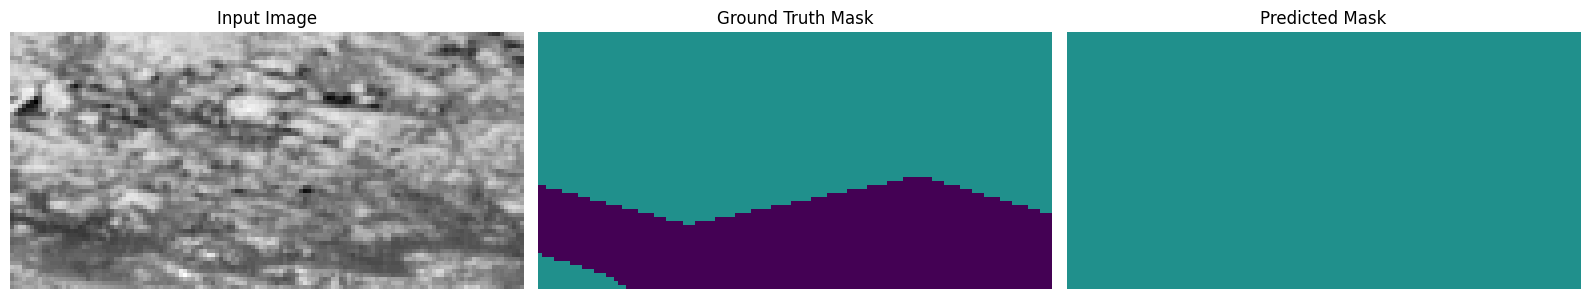

35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 718ms/step - accuracy: 0.6978 - loss: 0.2962 - mean_iou: 0.5578 - val_accuracy: 0.6812 - val_loss: 0.3759 - val_mean_iou: 0.6039
Epoch 157/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 708ms/step - accuracy: 0.6979 - loss: 0.2963 - mean_iou: 0.5490 - val_accuracy: 0.6900 - val_loss: 0.3401 - val_mean_iou: 0.6270
Epoch 158/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 679ms/step - accuracy: 0.7006 - loss: 0.2880 - mean_iou: 0.5550 - val_accuracy: 0.6981 - val_loss: 0.3269 - val_mean_iou: 0.6513
Epoch 159/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 689ms/step - accuracy: 0.6995 - loss: 0.3035 - mean_iou: 0.5752 - val_accuracy: 0.6841 - val_loss: 0.3594 - val_mean_iou: 0.6158
Epoch 160/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 686ms/step - accuracy: 0.6980 - loss: 0.2963 - mean_iou: 0.5737 - val_accuracy: 0.6994 - val_loss: 0.3319 - val_mean_iou: 0.6456
Epoch 161/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.6990 - loss: 0.3002 - mean_iou: 0.5713

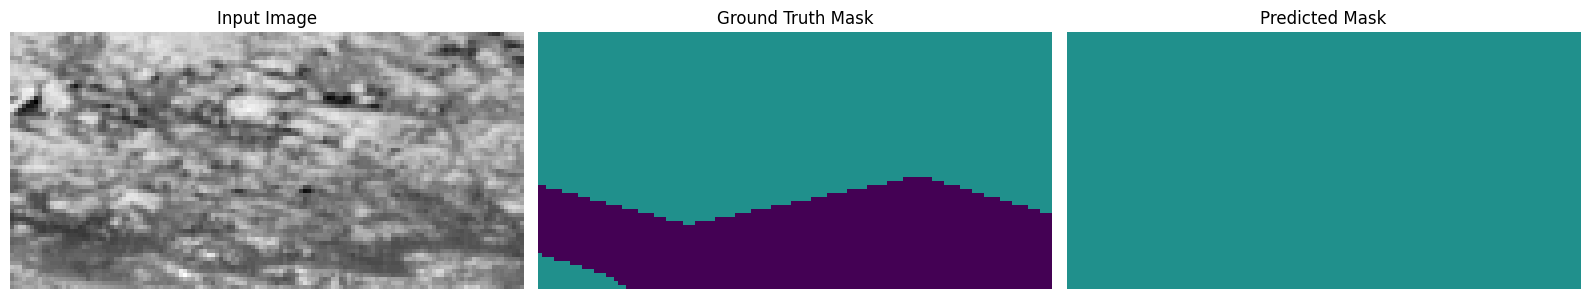

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 700ms/step - accuracy: 0.6994 - loss: 0.3000 - mean_iou: 0.5707 - val_accuracy: 0.7032 - val_loss: 0.3182 - val_mean_iou: 0.6442
Epoch 162/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 705ms/step - accuracy: 0.7045 - loss: 0.2932 - mean_iou: 0.5397 - val_accuracy: 0.6848 - val_loss: 0.3613 - val_mean_iou: 0.6267
Epoch 163/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 689ms/step - accuracy: 0.7057 - loss: 0.2926 - mean_iou: 0.5696 - val_accuracy: 0.6949 - val_loss: 0.3326 - val_mean_iou: 0.6287
Epoch 164/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 705ms/step - accuracy: 0.6987 - loss: 0.3001 - mean_iou: 0.5666 - val_accuracy: 0.6865 - val_loss: 0.3681 - val_mean_iou: 0.6140
Epoch 165/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 689ms/step - accuracy: 0.7096 - loss: 0.2893 - mean_iou: 0.5688 - val_accuracy: 0.6687 - val_loss: 0.4108 - val_mean_iou: 0.6161
Epoch 166/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7039 - loss: 0.2911 - mean_iou: 0.5705

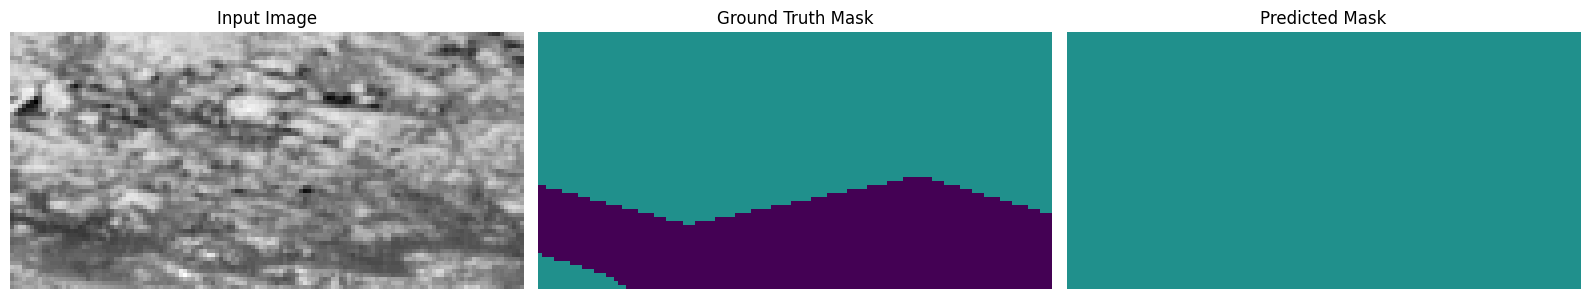

35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 720ms/step - accuracy: 0.7041 - loss: 0.2913 - mean_iou: 0.5700 - val_accuracy: 0.7024 - val_loss: 0.3250 - val_mean_iou: 0.6659
Epoch 167/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 707ms/step - accuracy: 0.7038 - loss: 0.2852 - mean_iou: 0.5676 - val_accuracy: 0.6895 - val_loss: 0.3460 - val_mean_iou: 0.6251
Epoch 168/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 704ms/step - accuracy: 0.7090 - loss: 0.2819 - mean_iou: 0.5922 - val_accuracy: 0.6881 - val_loss: 0.3596 - val_mean_iou: 0.6362
Epoch 169/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 692ms/step - accuracy: 0.7052 - loss: 0.2869 - mean_iou: 0.5706 - val_accuracy: 0.7064 - val_loss: 0.3158 - val_mean_iou: 0.6807
Epoch 170/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 707ms/step - accuracy: 0.6997 - loss: 0.2941 - mean_iou: 0.5569 - val_accuracy: 0.6239 - val_loss: 0.5142 - val_mean_iou: 0.5486
Epoch 171/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.7045 - loss: 0.2835 - mean_iou: 0.5436

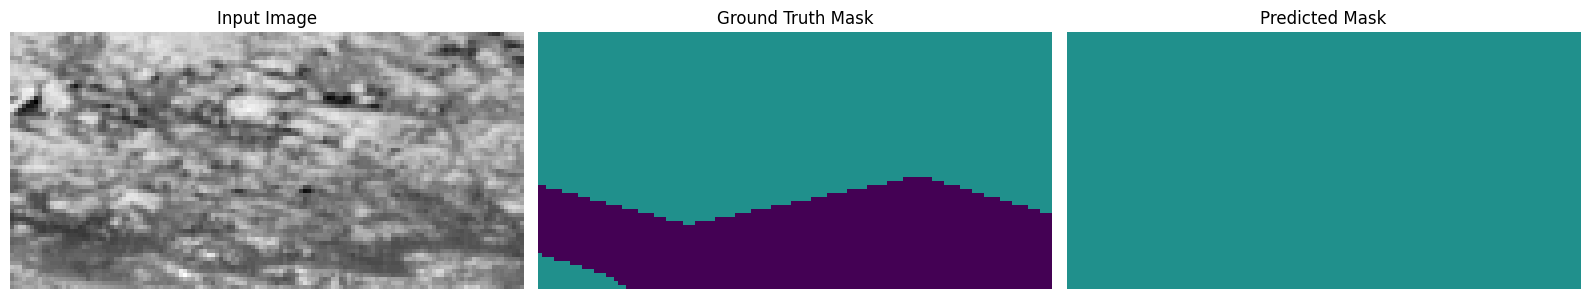

35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 697ms/step - accuracy: 0.7048 - loss: 0.2836 - mean_iou: 0.5437 - val_accuracy: 0.7012 - val_loss: 0.3239 - val_mean_iou: 0.6545
Epoch 172/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 683ms/step - accuracy: 0.7071 - loss: 0.2930 - mean_iou: 0.5987 - val_accuracy: 0.7019 - val_loss: 0.3197 - val_mean_iou: 0.6433
Epoch 173/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 700ms/step - accuracy: 0.7096 - loss: 0.2799 - mean_iou: 0.6404 - val_accuracy: 0.6453 - val_loss: 0.4764 - val_mean_iou: 0.5668
Epoch 174/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 703ms/step - accuracy: 0.6998 - loss: 0.3032 - mean_iou: 0.5306 - val_accuracy: 0.6994 - val_loss: 0.3285 - val_mean_iou: 0.6633
Epoch 175/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 702ms/step - accuracy: 0.7038 - loss: 0.2875 - mean_iou: 0.5610 - val_accuracy: 0.6911 - val_loss: 0.3507 - val_mean_iou: 0.6291
Epoch 176/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.7019 - loss: 0.2897 - mean_iou: 0.6233

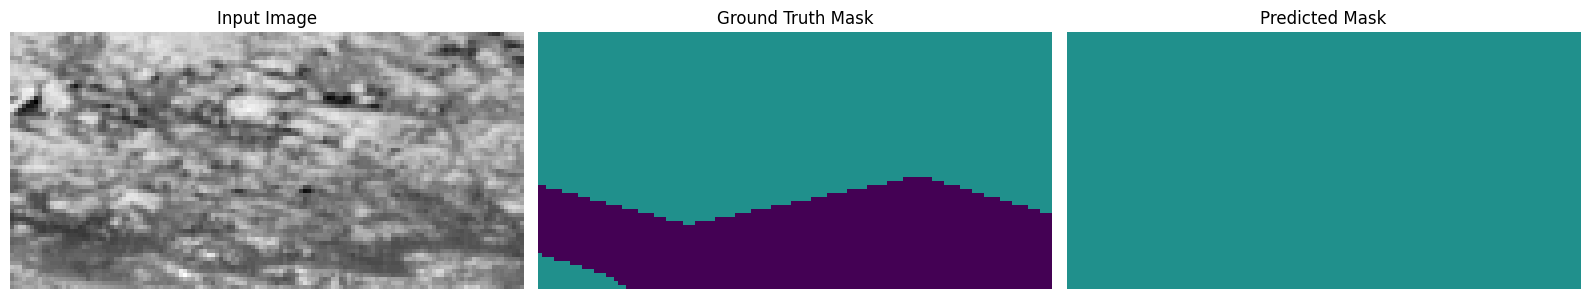

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 697ms/step - accuracy: 0.7023 - loss: 0.2895 - mean_iou: 0.6218 - val_accuracy: 0.6941 - val_loss: 0.3379 - val_mean_iou: 0.6323
Epoch 177/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 696ms/step - accuracy: 0.7077 - loss: 0.2884 - mean_iou: 0.5656 - val_accuracy: 0.6915 - val_loss: 0.3441 - val_mean_iou: 0.6568
Epoch 178/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 686ms/step - accuracy: 0.7022 - loss: 0.2825 - mean_iou: 0.5710 - val_accuracy: 0.7080 - val_loss: 0.3137 - val_mean_iou: 0.6618
Epoch 179/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 707ms/step - accuracy: 0.7009 - loss: 0.2880 - mean_iou: 0.5612 - val_accuracy: 0.6922 - val_loss: 0.3420 - val_mean_iou: 0.6378
Epoch 180/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 686ms/step - accuracy: 0.7050 - loss: 0.2834 - mean_iou: 0.5662 - val_accuracy: 0.7068 - val_loss: 0.3138 - val_mean_iou: 0.6564
Epoch 181/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7004 - loss: 0.2956 - mean_iou: 0.5722

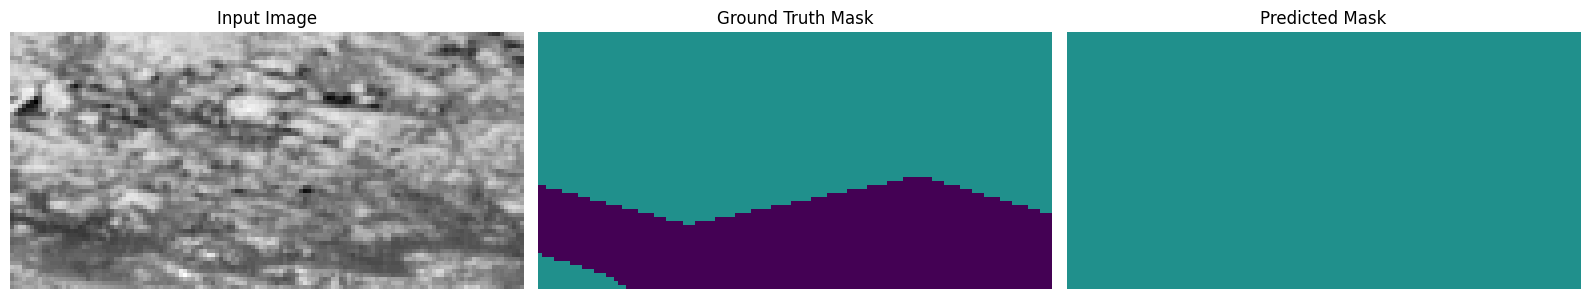

35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 722ms/step - accuracy: 0.7007 - loss: 0.2954 - mean_iou: 0.5719 - val_accuracy: 0.7001 - val_loss: 0.3172 - val_mean_iou: 0.6452
Epoch 182/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 707ms/step - accuracy: 0.7008 - loss: 0.2940 - mean_iou: 0.5844 - val_accuracy: 0.7048 - val_loss: 0.3148 - val_mean_iou: 0.6688
Epoch 183/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 690ms/step - accuracy: 0.7102 - loss: 0.2770 - mean_iou: 0.5825 - val_accuracy: 0.7059 - val_loss: 0.3178 - val_mean_iou: 0.6731
Epoch 184/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 691ms/step - accuracy: 0.7078 - loss: 0.2797 - mean_iou: 0.5625 - val_accuracy: 0.6936 - val_loss: 0.3309 - val_mean_iou: 0.6537
Epoch 185/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 715ms/step - accuracy: 0.7099 - loss: 0.2869 - mean_iou: 0.5680 - val_accuracy: 0.7060 - val_loss: 0.3067 - val_mean_iou: 0.6854
Epoch 186/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.7066 - loss: 0.2824 - mean_iou: 0.5703

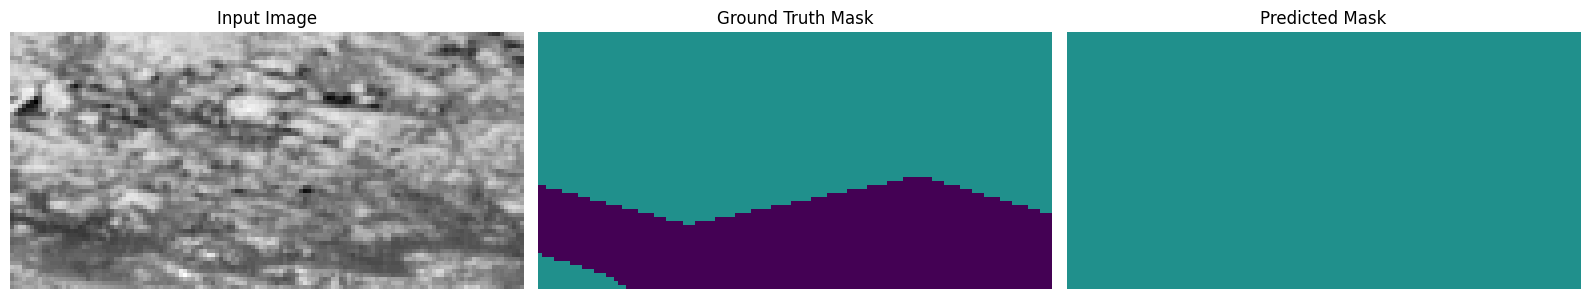

35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 698ms/step - accuracy: 0.7069 - loss: 0.2824 - mean_iou: 0.5700 - val_accuracy: 0.7005 - val_loss: 0.3325 - val_mean_iou: 0.6584
Epoch 187/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 688ms/step - accuracy: 0.7015 - loss: 0.2913 - mean_iou: 0.5618 - val_accuracy: 0.6842 - val_loss: 0.3626 - val_mean_iou: 0.6251
Epoch 188/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 684ms/step - accuracy: 0.7061 - loss: 0.2839 - mean_iou: 0.5539 - val_accuracy: 0.7022 - val_loss: 0.3252 - val_mean_iou: 0.6526
Epoch 189/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 688ms/step - accuracy: 0.7075 - loss: 0.2846 - mean_iou: 0.5399 - val_accuracy: 0.6941 - val_loss: 0.3407 - val_mean_iou: 0.6364
Epoch 190/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 687ms/step - accuracy: 0.7040 - loss: 0.2783 - mean_iou: 0.6056 - val_accuracy: 0.7009 - val_loss: 0.3368 - val_mean_iou: 0.6667
Epoch 191/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.7089 - loss: 0.2806 - mean_iou: 0.6682

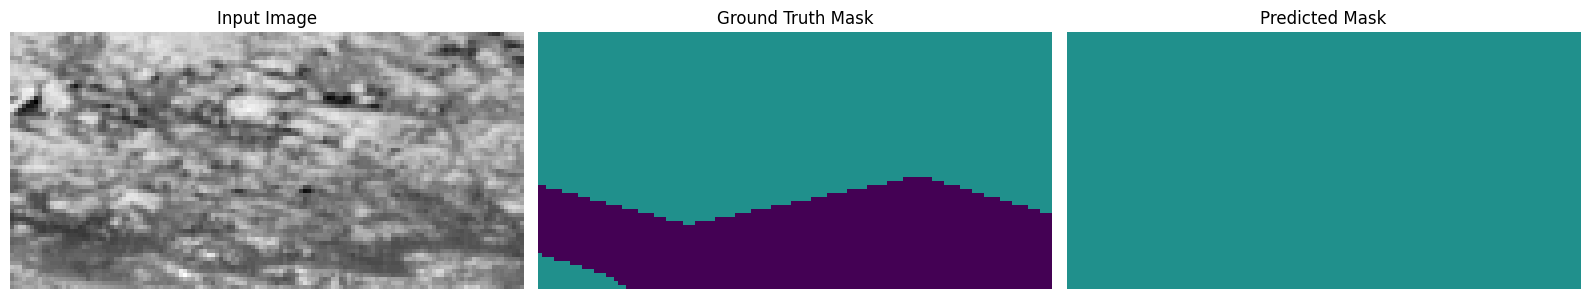

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 728ms/step - accuracy: 0.7091 - loss: 0.2807 - mean_iou: 0.6649 - val_accuracy: 0.7120 - val_loss: 0.2997 - val_mean_iou: 0.6766
Epoch 192/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 700ms/step - accuracy: 0.7146 - loss: 0.2654 - mean_iou: 0.6054 - val_accuracy: 0.6948 - val_loss: 0.3424 - val_mean_iou: 0.6796
Epoch 193/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 694ms/step - accuracy: 0.7055 - loss: 0.2810 - mean_iou: 0.5886 - val_accuracy: 0.7033 - val_loss: 0.3285 - val_mean_iou: 0.6589
Epoch 194/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 682ms/step - accuracy: 0.6987 - loss: 0.2936 - mean_iou: 0.5492 - val_accuracy: 0.7004 - val_loss: 0.3237 - val_mean_iou: 0.6612
Epoch 195/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 691ms/step - accuracy: 0.7053 - loss: 0.2810 - mean_iou: 0.6137 - val_accuracy: 0.7034 - val_loss: 0.3085 - val_mean_iou: 0.6718
Epoch 196/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.7044 - loss: 0.2855 - mean_iou: 0.5616

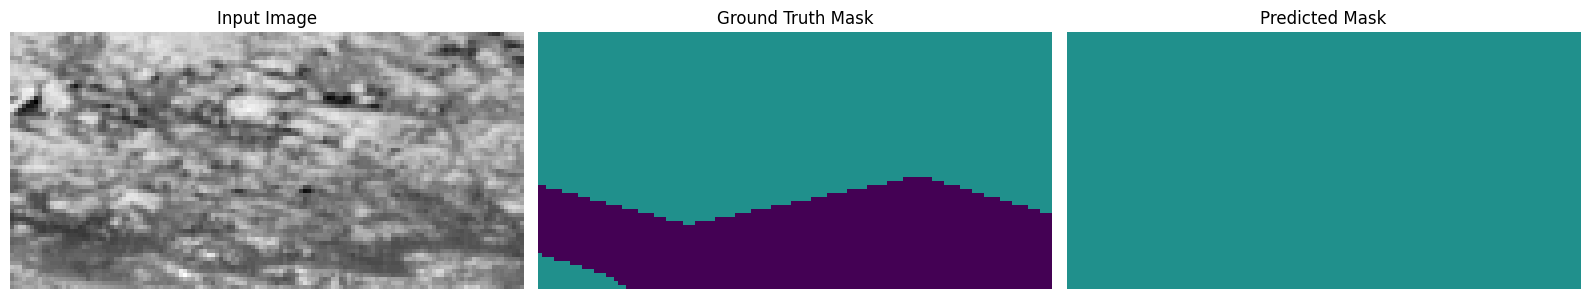

35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 713ms/step - accuracy: 0.7048 - loss: 0.2852 - mean_iou: 0.5614 - val_accuracy: 0.6826 - val_loss: 0.3761 - val_mean_iou: 0.6436
Epoch 197/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 704ms/step - accuracy: 0.7141 - loss: 0.2781 - mean_iou: 0.6031 - val_accuracy: 0.6921 - val_loss: 0.3465 - val_mean_iou: 0.6555
Epoch 198/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 710ms/step - accuracy: 0.7117 - loss: 0.2759 - mean_iou: 0.6071 - val_accuracy: 0.7037 - val_loss: 0.3186 - val_mean_iou: 0.6869
Epoch 199/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 704ms/step - accuracy: 0.7066 - loss: 0.2736 - mean_iou: 0.5750 - val_accuracy: 0.6999 - val_loss: 0.3248 - val_mean_iou: 0.6531
Epoch 200/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 708ms/step - accuracy: 0.7110 - loss: 0.2731 - mean_iou: 0.5964 - val_accuracy: 0.6993 - val_loss: 0.3240 - val_mean_iou: 0.6680
Epoch 201/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.7122 - loss: 0.2730 - mean_iou: 0.6239

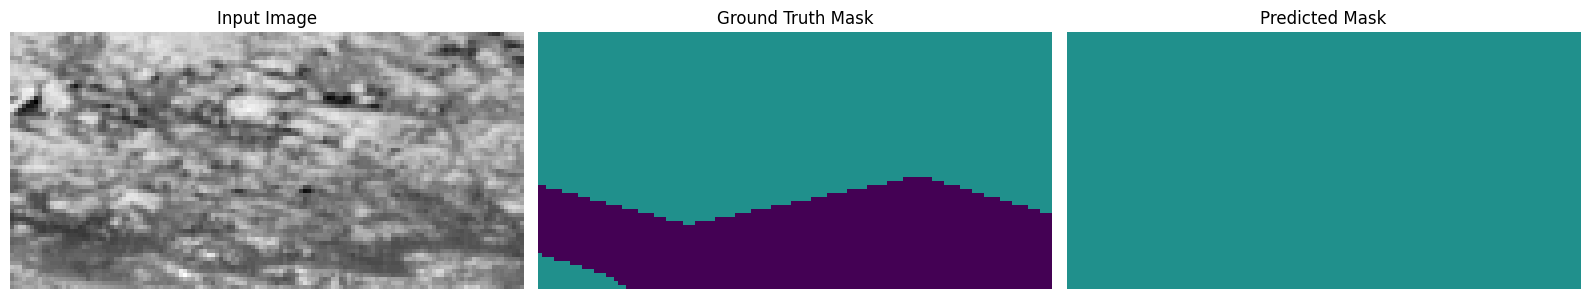

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 710ms/step - accuracy: 0.7124 - loss: 0.2731 - mean_iou: 0.6226 - val_accuracy: 0.6883 - val_loss: 0.3400 - val_mean_iou: 0.6547
Epoch 202/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 694ms/step - accuracy: 0.7018 - loss: 0.2924 - mean_iou: 0.5860 - val_accuracy: 0.7055 - val_loss: 0.3177 - val_mean_iou: 0.6826
Epoch 203/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 688ms/step - accuracy: 0.7080 - loss: 0.2810 - mean_iou: 0.5722 - val_accuracy: 0.6960 - val_loss: 0.3383 - val_mean_iou: 0.6550
Epoch 204/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 693ms/step - accuracy: 0.7134 - loss: 0.2680 - mean_iou: 0.6458 - val_accuracy: 0.6960 - val_loss: 0.3392 - val_mean_iou: 0.6628
Epoch 205/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 708ms/step - accuracy: 0.7070 - loss: 0.2814 - mean_iou: 0.5906 - val_accuracy: 0.7061 - val_loss: 0.3263 - val_mean_iou: 0.6901
Epoch 206/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.7101 - loss: 0.2717 - mean_iou: 0.5838

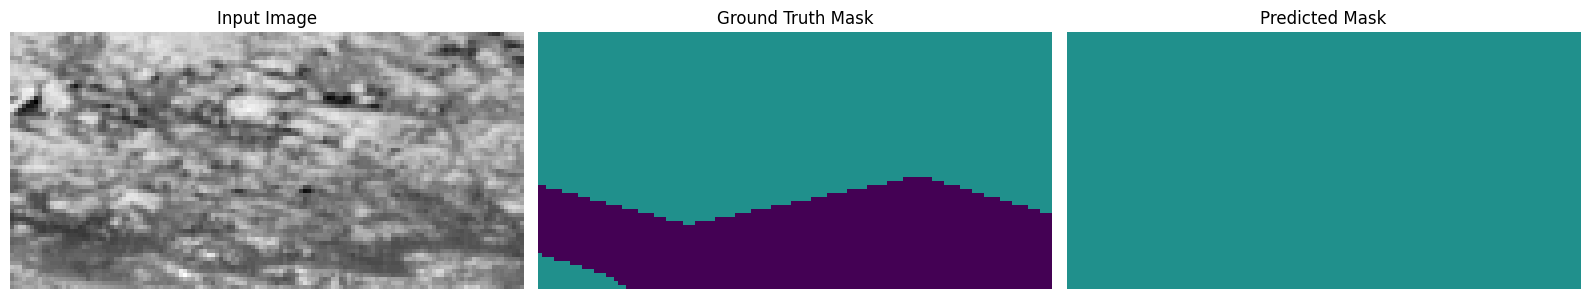

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 703ms/step - accuracy: 0.7104 - loss: 0.2717 - mean_iou: 0.5838 - val_accuracy: 0.7017 - val_loss: 0.3230 - val_mean_iou: 0.6693
Epoch 207/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 706ms/step - accuracy: 0.7104 - loss: 0.2720 - mean_iou: 0.5665 - val_accuracy: 0.6892 - val_loss: 0.3422 - val_mean_iou: 0.6482
Epoch 208/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 706ms/step - accuracy: 0.7120 - loss: 0.2789 - mean_iou: 0.5651 - val_accuracy: 0.6923 - val_loss: 0.3336 - val_mean_iou: 0.6599
Epoch 209/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 692ms/step - accuracy: 0.7069 - loss: 0.2781 - mean_iou: 0.5816 - val_accuracy: 0.6954 - val_loss: 0.3403 - val_mean_iou: 0.6681
Epoch 210/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 705ms/step - accuracy: 0.7126 - loss: 0.2688 - mean_iou: 0.6214 - val_accuracy: 0.6917 - val_loss: 0.3520 - val_mean_iou: 0.6472
Epoch 211/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.7113 - loss: 0.2705 - mean_iou: 0.6612

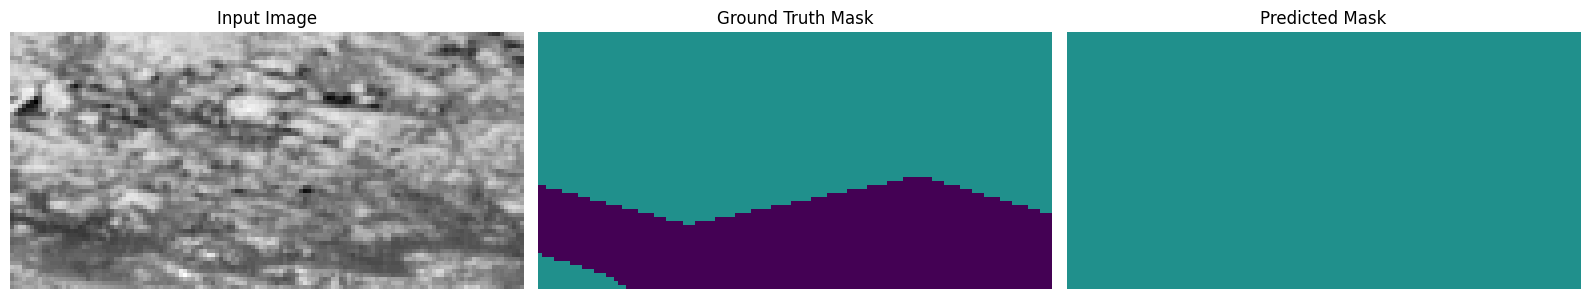

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 697ms/step - accuracy: 0.7115 - loss: 0.2706 - mean_iou: 0.6591 - val_accuracy: 0.6982 - val_loss: 0.3296 - val_mean_iou: 0.6792
Epoch 212/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 701ms/step - accuracy: 0.7170 - loss: 0.2628 - mean_iou: 0.6777 - val_accuracy: 0.6889 - val_loss: 0.3449 - val_mean_iou: 0.6636
Epoch 213/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 705ms/step - accuracy: 0.7114 - loss: 0.2771 - mean_iou: 0.5769 - val_accuracy: 0.6921 - val_loss: 0.3459 - val_mean_iou: 0.6821
Epoch 214/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 700ms/step - accuracy: 0.7080 - loss: 0.2768 - mean_iou: 0.6041 - val_accuracy: 0.6988 - val_loss: 0.3236 - val_mean_iou: 0.6738
Epoch 215/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 692ms/step - accuracy: 0.7196 - loss: 0.2680 - mean_iou: 0.6190 - val_accuracy: 0.6969 - val_loss: 0.3333 - val_mean_iou: 0.6746
Epoch 216/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7120 - loss: 0.2709 - mean_iou: 0.6680

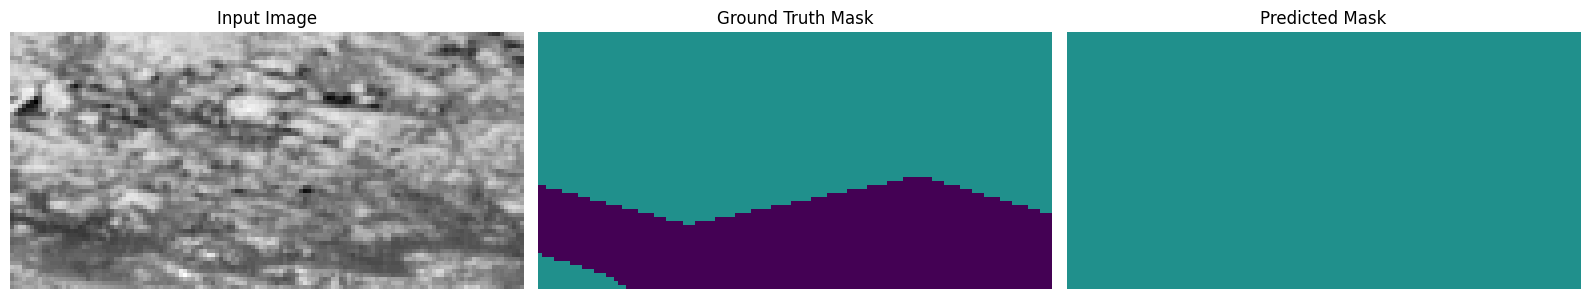

35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 713ms/step - accuracy: 0.7121 - loss: 0.2711 - mean_iou: 0.6656 - val_accuracy: 0.7019 - val_loss: 0.3188 - val_mean_iou: 0.6736
Epoch 217/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 714ms/step - accuracy: 0.7136 - loss: 0.2676 - mean_iou: 0.6268 - val_accuracy: 0.7081 - val_loss: 0.3080 - val_mean_iou: 0.7094
Epoch 218/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 710ms/step - accuracy: 0.7139 - loss: 0.2651 - mean_iou: 0.6039 - val_accuracy: 0.6974 - val_loss: 0.3227 - val_mean_iou: 0.6581
Epoch 219/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 691ms/step - accuracy: 0.7137 - loss: 0.2667 - mean_iou: 0.6305 - val_accuracy: 0.6990 - val_loss: 0.3236 - val_mean_iou: 0.6760
Epoch 220/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 688ms/step - accuracy: 0.7128 - loss: 0.2700 - mean_iou: 0.5843 - val_accuracy: 0.6976 - val_loss: 0.3310 - val_mean_iou: 0.6746
Epoch 221/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.7084 - loss: 0.2718 - mean_iou: 0.5856

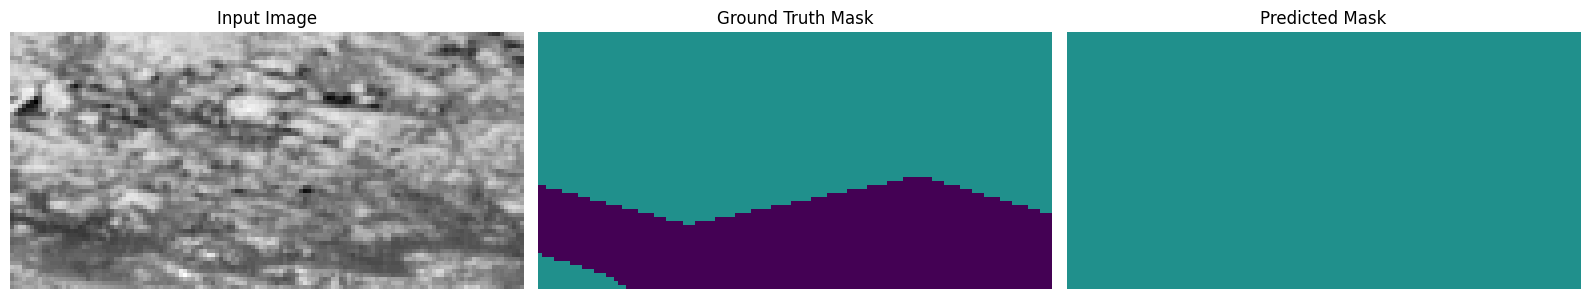

35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 718ms/step - accuracy: 0.7087 - loss: 0.2719 - mean_iou: 0.5857 - val_accuracy: 0.7038 - val_loss: 0.3197 - val_mean_iou: 0.6903
Epoch 222/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 704ms/step - accuracy: 0.7068 - loss: 0.2781 - mean_iou: 0.5687 - val_accuracy: 0.7041 - val_loss: 0.3186 - val_mean_iou: 0.6857
Epoch 223/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 690ms/step - accuracy: 0.7201 - loss: 0.2628 - mean_iou: 0.6631 - val_accuracy: 0.7069 - val_loss: 0.3123 - val_mean_iou: 0.6990
Epoch 224/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 706ms/step - accuracy: 0.7110 - loss: 0.2698 - mean_iou: 0.6061 - val_accuracy: 0.6987 - val_loss: 0.3241 - val_mean_iou: 0.6742
Epoch 225/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 704ms/step - accuracy: 0.7149 - loss: 0.2686 - mean_iou: 0.6263 - val_accuracy: 0.6978 - val_loss: 0.3300 - val_mean_iou: 0.6750
Epoch 226/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7150 - loss: 0.2702 - mean_iou: 0.6254

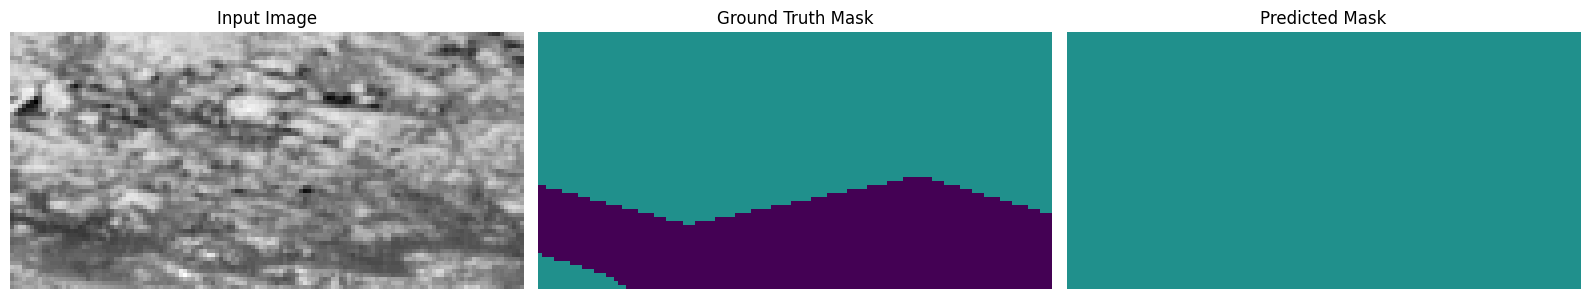

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 713ms/step - accuracy: 0.7151 - loss: 0.2704 - mean_iou: 0.6239 - val_accuracy: 0.7001 - val_loss: 0.3177 - val_mean_iou: 0.6810
Epoch 227/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 713ms/step - accuracy: 0.7164 - loss: 0.2598 - mean_iou: 0.6679 - val_accuracy: 0.7003 - val_loss: 0.3171 - val_mean_iou: 0.6843
Epoch 228/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 702ms/step - accuracy: 0.7133 - loss: 0.2633 - mean_iou: 0.5749 - val_accuracy: 0.7048 - val_loss: 0.3212 - val_mean_iou: 0.6874
Epoch 229/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 695ms/step - accuracy: 0.7202 - loss: 0.2585 - mean_iou: 0.6351 - val_accuracy: 0.7029 - val_loss: 0.3229 - val_mean_iou: 0.6947
Epoch 230/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 702ms/step - accuracy: 0.7121 - loss: 0.2678 - mean_iou: 0.7102 - val_accuracy: 0.7045 - val_loss: 0.3121 - val_mean_iou: 0.7008
Epoch 231/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.7092 - loss: 0.2746 - mean_iou: 0.5940

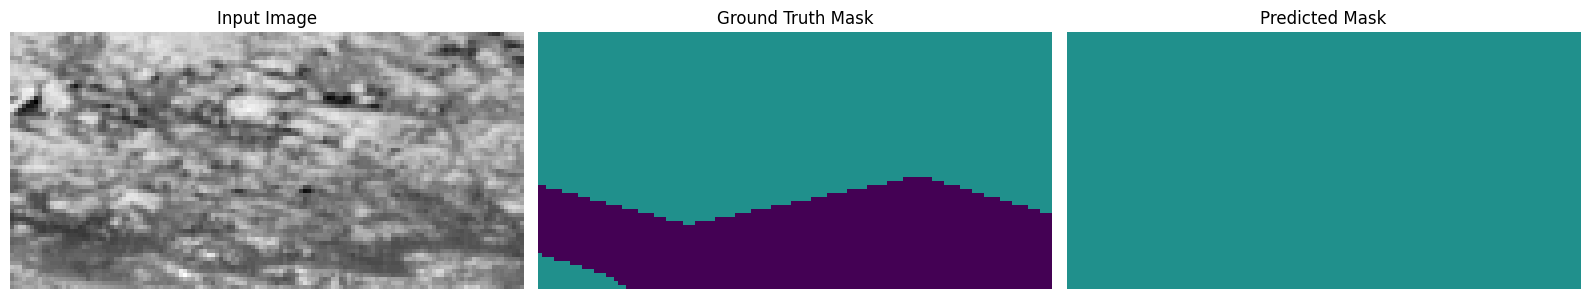

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 711ms/step - accuracy: 0.7095 - loss: 0.2744 - mean_iou: 0.5939 - val_accuracy: 0.6980 - val_loss: 0.3302 - val_mean_iou: 0.6798
Epoch 232/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 686ms/step - accuracy: 0.7178 - loss: 0.2652 - mean_iou: 0.6187 - val_accuracy: 0.7016 - val_loss: 0.3221 - val_mean_iou: 0.6808
Epoch 233/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 705ms/step - accuracy: 0.7152 - loss: 0.2666 - mean_iou: 0.5910 - val_accuracy: 0.7019 - val_loss: 0.3254 - val_mean_iou: 0.6817
Epoch 234/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 704ms/step - accuracy: 0.7145 - loss: 0.2692 - mean_iou: 0.6960 - val_accuracy: 0.7021 - val_loss: 0.3282 - val_mean_iou: 0.6820
Epoch 235/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 708ms/step - accuracy: 0.7124 - loss: 0.2665 - mean_iou: 0.6281 - val_accuracy: 0.7063 - val_loss: 0.3123 - val_mean_iou: 0.6995
Epoch 236/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7129 - loss: 0.2647 - mean_iou: 0.6260

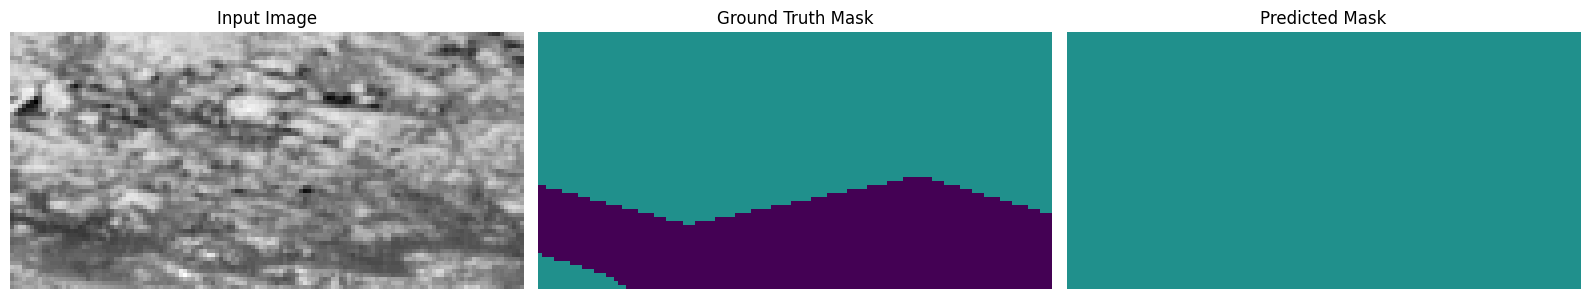

35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 695ms/step - accuracy: 0.7131 - loss: 0.2648 - mean_iou: 0.6247 - val_accuracy: 0.7027 - val_loss: 0.3169 - val_mean_iou: 0.6793
Epoch 237/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 701ms/step - accuracy: 0.7143 - loss: 0.2618 - mean_iou: 0.7557 - val_accuracy: 0.7049 - val_loss: 0.3132 - val_mean_iou: 0.7031
Epoch 238/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 710ms/step - accuracy: 0.7155 - loss: 0.2659 - mean_iou: 0.5917 - val_accuracy: 0.7058 - val_loss: 0.3119 - val_mean_iou: 0.6906
Epoch 239/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 681ms/step - accuracy: 0.7153 - loss: 0.2607 - mean_iou: 0.7036 - val_accuracy: 0.7019 - val_loss: 0.3223 - val_mean_iou: 0.6826
Epoch 240/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 699ms/step - accuracy: 0.7118 - loss: 0.2755 - mean_iou: 0.6240 - val_accuracy: 0.6995 - val_loss: 0.3246 - val_mean_iou: 0.6797
Epoch 241/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.7176 - loss: 0.2546 - mean_iou: 0.6724

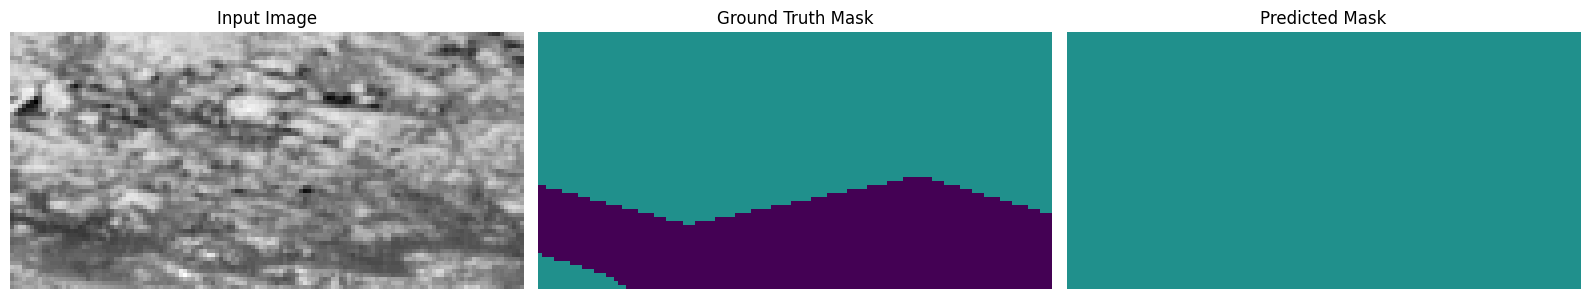

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 710ms/step - accuracy: 0.7177 - loss: 0.2549 - mean_iou: 0.6698 - val_accuracy: 0.6994 - val_loss: 0.3259 - val_mean_iou: 0.6677
Epoch 242/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 691ms/step - accuracy: 0.7123 - loss: 0.2650 - mean_iou: 0.5997 - val_accuracy: 0.7061 - val_loss: 0.3239 - val_mean_iou: 0.6853
Epoch 243/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 691ms/step - accuracy: 0.7131 - loss: 0.2660 - mean_iou: 0.7106 - val_accuracy: 0.6998 - val_loss: 0.3331 - val_mean_iou: 0.6673
Epoch 244/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 689ms/step - accuracy: 0.7130 - loss: 0.2637 - mean_iou: 0.5979 - val_accuracy: 0.7064 - val_loss: 0.3122 - val_mean_iou: 0.6880
Epoch 245/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 686ms/step - accuracy: 0.7168 - loss: 0.2586 - mean_iou: 0.6656 - val_accuracy: 0.7032 - val_loss: 0.3201 - val_mean_iou: 0.6966
Epoch 246/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.7153 - loss: 0.2608 - mean_iou: 0.6055

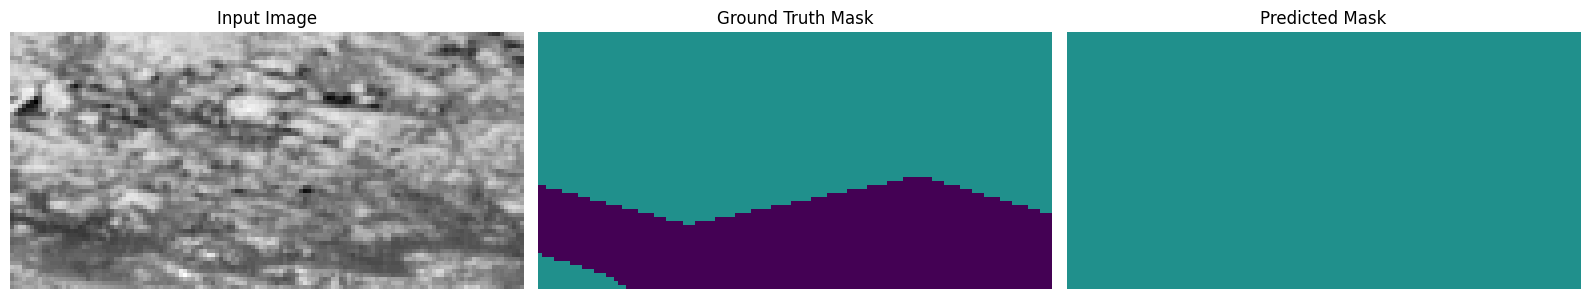

35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 701ms/step - accuracy: 0.7155 - loss: 0.2609 - mean_iou: 0.6049 - val_accuracy: 0.6984 - val_loss: 0.3389 - val_mean_iou: 0.6773
Epoch 247/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 682ms/step - accuracy: 0.7145 - loss: 0.2649 - mean_iou: 0.6728 - val_accuracy: 0.7047 - val_loss: 0.3230 - val_mean_iou: 0.6821
Final validation Mean Intersection Over Union: 70.94%


In [13]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

In [14]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_MultiResNet_{timestep_str}_{str(final_val_meanIoU)}.keras"
model.save(model_filename)


In [15]:
#del model

print(f"Model saved to {model_filename}")

Model saved to model_MultiResNet_241214_205653_70.94.keras


## Results

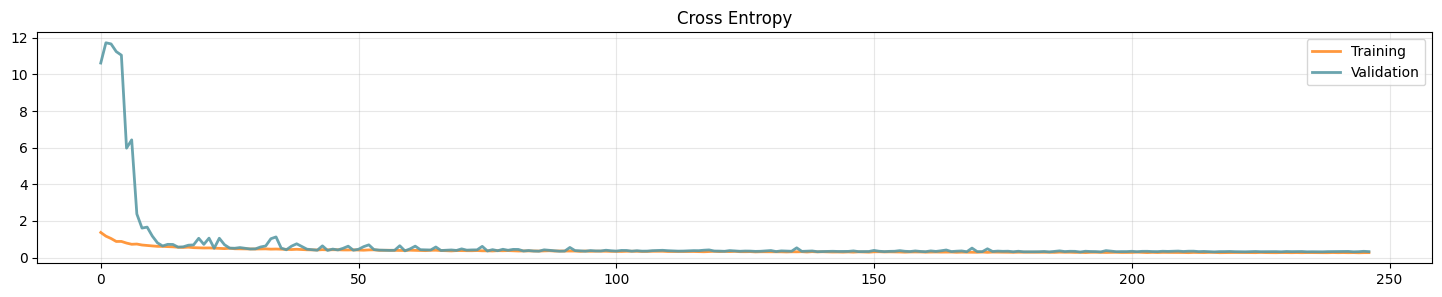

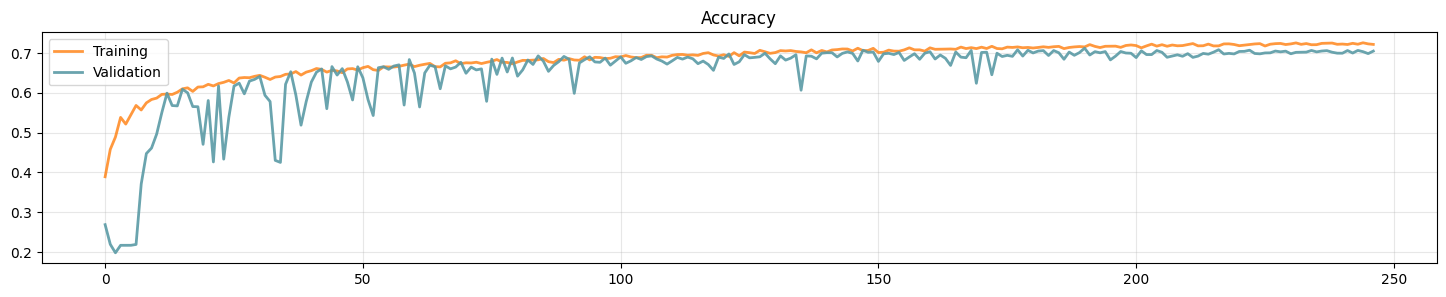

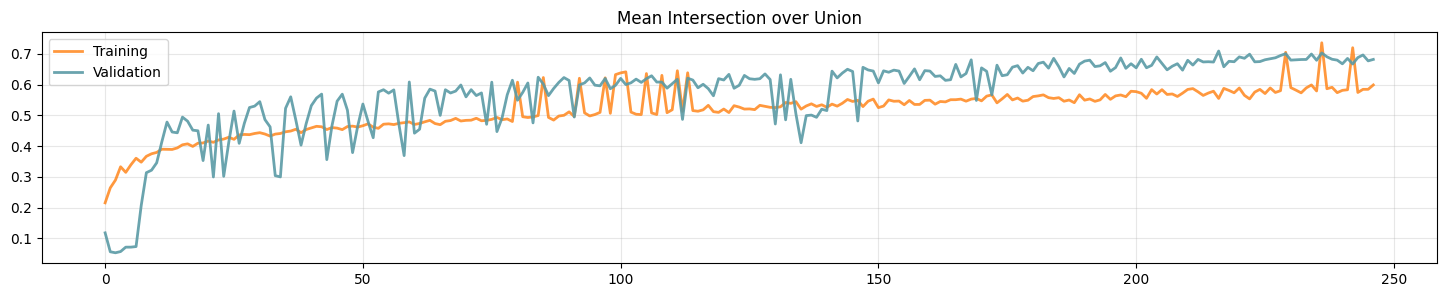

In [16]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [17]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [18]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 64, 128, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 8, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 1]}, 'name': 'conv2d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 1], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 8]}, 'name': 'batch_normalization_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['conv2d_1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 8]}, 'name': 'activation', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['batch_normalization_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 17, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 8]}, 'name': 'conv2d_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['activation', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 17]}, 'name': 'batch_normalization_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['conv2d_2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 17]}, 'name': 'activation_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['batch_normalization_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 26, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 17]}, 'name': 'conv2d_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['activation_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 26]}, 'name': 'batch_normalization_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 26], 'dtype': 'float32', 'keras_history': ['conv2d_3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 26]}, 'name': 'activation_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 26], 'dtype': 'float32', 'keras_history': ['batch_normalization_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 51, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 1]}, 'name': 'conv2d', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 1], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 8], [None, 64, 128, 17], [None, 64, 128, 26]]}, 'name': 'concatenate', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['activation', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['activation_1', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 26], 'dtype': 'float32', 'keras_history': ['activation_2', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'batch_normalization', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['conv2d', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'batch_normalization_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['concatenate', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 51], [None, 64, 128, 51]]}, 'name': 'add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_4', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'activation_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'batch_normalization_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['activation_3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'max_pooling2d', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 17, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 51]}, 'name': 'conv2d_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 51], 'dtype': 'float32', 'keras_history': ['max_pooling2d', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_19', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 17]}, 'name': 'batch_normalization_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['conv2d_13', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 17]}, 'name': 'activation_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['batch_normalization_19', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 35, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 17]}, 'name': 'conv2d_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['activation_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_20', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 35]}, 'name': 'batch_normalization_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['conv2d_14', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 35]}, 'name': 'activation_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['batch_normalization_20', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 53, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 35]}, 'name': 'conv2d_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['activation_13', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_21', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 53]}, 'name': 'batch_normalization_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 53], 'dtype': 'float32', 'keras_history': ['conv2d_15', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 53]}, 'name': 'activation_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 53], 'dtype': 'float32', 'keras_history': ['batch_normalization_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 105, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 51]}, 'name': 'conv2d_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 51], 'dtype': 'float32', 'keras_history': ['max_pooling2d', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 17], [None, 32, 64, 35], [None, 32, 64, 53]]}, 'name': 'concatenate_1', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['activation_12', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['activation_13', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 53], 'dtype': 'float32', 'keras_history': ['activation_14', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_18', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'batch_normalization_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['conv2d_12', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_22', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'batch_normalization_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['concatenate_1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 105], [None, 32, 64, 105]]}, 'name': 'add_5', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_18', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_22', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'activation_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['add_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_23', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'batch_normalization_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['activation_15', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'max_pooling2d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_23', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 35, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 105]}, 'name': 'conv2d_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 105], 'dtype': 'float32', 'keras_history': ['max_pooling2d_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_34', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 35]}, 'name': 'batch_normalization_34', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['conv2d_23', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_22', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 35]}, 'name': 'activation_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['batch_normalization_34', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_24', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 71, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 35]}, 'name': 'conv2d_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['activation_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_35', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 71]}, 'name': 'batch_normalization_35', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['conv2d_24', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_23', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 71]}, 'name': 'activation_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['batch_normalization_35', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_25', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 106, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 71]}, 'name': 'conv2d_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['activation_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_36', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 106]}, 'name': 'batch_normalization_36', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 106], 'dtype': 'float32', 'keras_history': ['conv2d_25', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_24', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 106]}, 'name': 'activation_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 106], 'dtype': 'float32', 'keras_history': ['batch_normalization_36', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_22', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 212, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 105]}, 'name': 'conv2d_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 105], 'dtype': 'float32', 'keras_history': ['max_pooling2d_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 35], [None, 16, 32, 71], [None, 16, 32, 106]]}, 'name': 'concatenate_2', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['activation_22', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['activation_23', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 106], 'dtype': 'float32', 'keras_history': ['activation_24', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_33', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'batch_normalization_33', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['conv2d_22', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_37', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'batch_normalization_37', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['concatenate_2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 212], [None, 16, 32, 212]]}, 'name': 'add_9', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_33', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_37', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_25', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'activation_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['add_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_38', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'batch_normalization_38', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['activation_25', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'max_pooling2d_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_38', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_31', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 71, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 212]}, 'name': 'conv2d_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 212], 'dtype': 'float32', 'keras_history': ['max_pooling2d_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_46', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 71]}, 'name': 'batch_normalization_46', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['conv2d_31', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_30', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 71]}, 'name': 'activation_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['batch_normalization_46', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_32', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 142, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 71]}, 'name': 'conv2d_32', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['activation_30', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_47', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 142]}, 'name': 'batch_normalization_47', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['conv2d_32', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_31', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 142]}, 'name': 'activation_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['batch_normalization_47', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_33', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 213, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 142]}, 'name': 'conv2d_33', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['activation_31', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_48', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 213]}, 'name': 'batch_normalization_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 213], 'dtype': 'float32', 'keras_history': ['conv2d_33', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_32', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 213]}, 'name': 'activation_32', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 213], 'dtype': 'float32', 'keras_history': ['batch_normalization_48', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_30', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 426, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 212]}, 'name': 'conv2d_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 212], 'dtype': 'float32', 'keras_history': ['max_pooling2d_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 71], [None, 8, 16, 142], [None, 8, 16, 213]]}, 'name': 'concatenate_3', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['activation_30', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['activation_31', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 213], 'dtype': 'float32', 'keras_history': ['activation_32', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_45', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'batch_normalization_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['conv2d_30', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_49', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'batch_normalization_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['concatenate_3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 426], [None, 8, 16, 426]]}, 'name': 'add_12', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_45', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_49', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_33', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'activation_33', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['add_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_50', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'batch_normalization_50', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['activation_33', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'max_pooling2d_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_50', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_37', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 142, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 426]}, 'name': 'conv2d_37', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 426], 'dtype': 'float32', 'keras_history': ['max_pooling2d_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_55', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 142]}, 'name': 'batch_normalization_55', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 142], 'dtype': 'float32', 'keras_history': ['conv2d_37', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_36', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 142]}, 'name': 'activation_36', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 142], 'dtype': 'float32', 'keras_history': ['batch_normalization_55', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_38', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 284, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 142]}, 'name': 'conv2d_38', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 142], 'dtype': 'float32', 'keras_history': ['activation_36', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_56', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 284]}, 'name': 'batch_normalization_56', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 284], 'dtype': 'float32', 'keras_history': ['conv2d_38', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_37', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 284]}, 'name': 'activation_37', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 284], 'dtype': 'float32', 'keras_history': ['batch_normalization_56', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_39', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 427, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 284]}, 'name': 'conv2d_39', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 284], 'dtype': 'float32', 'keras_history': ['activation_37', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_57', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 427]}, 'name': 'batch_normalization_57', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 427], 'dtype': 'float32', 'keras_history': ['conv2d_39', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_38', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 427]}, 'name': 'activation_38', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 427], 'dtype': 'float32', 'keras_history': ['batch_normalization_57', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_36', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 853, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 426]}, 'name': 'conv2d_36', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 426], 'dtype': 'float32', 'keras_history': ['max_pooling2d_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 4, 8, 142], [None, 4, 8, 284], [None, 4, 8, 427]]}, 'name': 'concatenate_4', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 142], 'dtype': 'float32', 'keras_history': ['activation_36', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 284], 'dtype': 'float32', 'keras_history': ['activation_37', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 427], 'dtype': 'float32', 'keras_history': ['activation_38', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_54', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'batch_normalization_54', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['conv2d_36', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_58', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'batch_normalization_58', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['concatenate_4', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 4, 8, 853], [None, 4, 8, 853]]}, 'name': 'add_14', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['batch_normalization_54', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['batch_normalization_58', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_39', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'activation_39', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['add_14', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_59', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'batch_normalization_59', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['activation_39', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_35', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'conv2d_35', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_50', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_40', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'conv2d_40', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['batch_normalization_59', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_41', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'conv2d_41', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['batch_normalization_59', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_42', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [2, 2], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'conv2d_42', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['batch_normalization_59', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_34', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'conv2d_34', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_50', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_52', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'batch_normalization_52', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_35', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 4, 8, 256], [None, 4, 8, 256], [None, 4, 8, 256]]}, 'name': 'concatenate_5', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['conv2d_40', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['conv2d_41', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['conv2d_42', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_51', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'batch_normalization_51', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_34', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_34', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'activation_34', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_52', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_43', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 768]}, 'name': 'conv2d_43', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 768], 'dtype': 'float32', 'keras_history': ['concatenate_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 256], [None, 8, 16, 256]]}, 'name': 'add_13', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_51', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['activation_34', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_40', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 256]}, 'name': 'activation_40', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['conv2d_43', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_35', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'activation_35', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['add_13', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_45', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 256]}, 'name': 'conv2d_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['activation_40', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_53', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'batch_normalization_53', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['activation_35', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 256]}, 'name': 'conv2d_transpose', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['conv2d_45', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_44', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'conv2d_44', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_53', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 4, 8, 256], [None, 4, 8, 256]]}, 'name': 'add_15', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['conv2d_transpose', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['conv2d_44', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_41', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 256]}, 'name': 'activation_41', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['add_15', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_46', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 256]}, 'name': 'conv2d_46', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 256], 'dtype': 'float32', 'keras_history': ['activation_41', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_42', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'sigmoid'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 1]}, 'name': 'activation_42', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 1], 'dtype': 'float32', 'keras_history': ['conv2d_46', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'size': [2, 2], 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 1]}, 'name': 'up_sampling2d', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 1], 'dtype': 'float32', 'keras_history': ['activation_42', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'RepeatElementsLayer', 'config': {'name': 'repeat_elements_layer', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'rep': 256, 'axis': 3}, 'registered_name': 'RepeatElementsLayer', 'build_config': {'input_shape': [None, 8, 16, 1]}, 'name': 'repeat_elements_layer', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 1], 'dtype': 'float32', 'keras_history': ['up_sampling2d', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 256], [None, 8, 16, 256]]}, 'name': 'multiply', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['repeat_elements_layer', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_53', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_47', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'conv2d_47', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['multiply', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 8, 853]}, 'name': 'conv2d_transpose_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 8, 853], 'dtype': 'float32', 'keras_history': ['batch_normalization_59', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_60', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 256]}, 'name': 'batch_normalization_60', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_47', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 256], [None, 8, 16, 256]]}, 'name': 'concatenate_6', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_1', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_60', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_49', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 71, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 512]}, 'name': 'conv2d_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 512], 'dtype': 'float32', 'keras_history': ['concatenate_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_62', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 71]}, 'name': 'batch_normalization_62', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['conv2d_49', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_43', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 71]}, 'name': 'activation_43', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['batch_normalization_62', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_50', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 142, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 71]}, 'name': 'conv2d_50', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['activation_43', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_63', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 142]}, 'name': 'batch_normalization_63', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['conv2d_50', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_44', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 142]}, 'name': 'activation_44', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['batch_normalization_63', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_51', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 213, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 142]}, 'name': 'conv2d_51', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['activation_44', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_64', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 213]}, 'name': 'batch_normalization_64', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 213], 'dtype': 'float32', 'keras_history': ['conv2d_51', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_27', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'conv2d_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_38', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_45', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 213]}, 'name': 'activation_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 213], 'dtype': 'float32', 'keras_history': ['batch_normalization_64', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_26', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'conv2d_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_38', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_40', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_40', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_27', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_48', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 426, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 512]}, 'name': 'conv2d_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 512], 'dtype': 'float32', 'keras_history': ['concatenate_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 71], [None, 8, 16, 142], [None, 8, 16, 213]]}, 'name': 'concatenate_7', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 71], 'dtype': 'float32', 'keras_history': ['activation_43', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 142], 'dtype': 'float32', 'keras_history': ['activation_44', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 213], 'dtype': 'float32', 'keras_history': ['activation_45', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_39', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_39', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_26', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_26', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'activation_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_40', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_61', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'batch_normalization_61', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['conv2d_48', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_65', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'batch_normalization_65', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['concatenate_7', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 128], [None, 16, 32, 128]]}, 'name': 'add_10', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_39', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['activation_26', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 426], [None, 8, 16, 426]]}, 'name': 'add_16', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_61', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_65', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_27', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'activation_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['add_10', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_46', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'activation_46', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['add_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_41', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_41', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['activation_27', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_66', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'batch_normalization_66', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['activation_46', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_29', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'conv2d_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_41', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_52', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'conv2d_52', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_66', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_53', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'conv2d_53', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_66', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_54', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [2, 2], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'conv2d_54', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_66', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_28', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'conv2d_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_41', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_43', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_43', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_29', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 256], [None, 8, 16, 256], [None, 8, 16, 256]]}, 'name': 'concatenate_8', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_52', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_53', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_54', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_42', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_42', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_28', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_28', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'activation_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_43', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_55', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 768]}, 'name': 'conv2d_55', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 768], 'dtype': 'float32', 'keras_history': ['concatenate_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 128], [None, 16, 32, 128]]}, 'name': 'add_11', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_42', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['activation_28', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_47', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 128]}, 'name': 'activation_47', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['conv2d_55', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_29', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'activation_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['add_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_57', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 128]}, 'name': 'conv2d_57', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['activation_47', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_44', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_44', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['activation_29', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 128]}, 'name': 'conv2d_transpose_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['conv2d_57', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_56', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 128, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'conv2d_56', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_44', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_17', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 16, 128], [None, 8, 16, 128]]}, 'name': 'add_17', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_2', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['conv2d_56', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_48', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 128]}, 'name': 'activation_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['add_17', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_58', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 128]}, 'name': 'conv2d_58', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 128], 'dtype': 'float32', 'keras_history': ['activation_48', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_49', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'sigmoid'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 1]}, 'name': 'activation_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 1], 'dtype': 'float32', 'keras_history': ['conv2d_58', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'size': [2, 2], 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 1]}, 'name': 'up_sampling2d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 1], 'dtype': 'float32', 'keras_history': ['activation_49', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'RepeatElementsLayer', 'config': {'name': 'repeat_elements_layer_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'rep': 128, 'axis': 3}, 'registered_name': 'RepeatElementsLayer', 'build_config': {'input_shape': [None, 16, 32, 1]}, 'name': 'repeat_elements_layer_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 1], 'dtype': 'float32', 'keras_history': ['up_sampling2d_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 128], [None, 16, 32, 128]]}, 'name': 'multiply_1', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['repeat_elements_layer_1', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_44', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_59', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'conv2d_59', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['multiply_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 128, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 16, 426]}, 'name': 'conv2d_transpose_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 426], 'dtype': 'float32', 'keras_history': ['batch_normalization_66', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_67', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 128]}, 'name': 'batch_normalization_67', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_59', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 128], [None, 16, 32, 128]]}, 'name': 'concatenate_9', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_3', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_67', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_61', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 35, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 256]}, 'name': 'conv2d_61', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 256], 'dtype': 'float32', 'keras_history': ['concatenate_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_69', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 35]}, 'name': 'batch_normalization_69', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['conv2d_61', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_17', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'conv2d_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_50', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 35]}, 'name': 'activation_50', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['batch_normalization_69', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'conv2d_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_25', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_17', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_62', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 71, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 35]}, 'name': 'conv2d_62', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['activation_50', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_24', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_16', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'activation_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_70', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 71]}, 'name': 'batch_normalization_70', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['conv2d_62', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 64], [None, 32, 64, 64]]}, 'name': 'add_6', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_24', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['activation_16', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_51', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 71]}, 'name': 'activation_51', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['batch_normalization_70', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_17', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'activation_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['add_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_63', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 106, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 71]}, 'name': 'conv2d_63', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['activation_51', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_26', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['activation_17', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_71', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 106]}, 'name': 'batch_normalization_71', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 106], 'dtype': 'float32', 'keras_history': ['conv2d_63', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_19', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'conv2d_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_26', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_52', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 106]}, 'name': 'activation_52', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 106], 'dtype': 'float32', 'keras_history': ['batch_normalization_71', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_18', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'conv2d_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_26', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_28', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_19', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_60', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 212, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 256]}, 'name': 'conv2d_60', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 256], 'dtype': 'float32', 'keras_history': ['concatenate_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 35], [None, 16, 32, 71], [None, 16, 32, 106]]}, 'name': 'concatenate_10', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 35], 'dtype': 'float32', 'keras_history': ['activation_50', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 71], 'dtype': 'float32', 'keras_history': ['activation_51', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 106], 'dtype': 'float32', 'keras_history': ['activation_52', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_27', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_18', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_18', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'activation_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_28', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_68', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'batch_normalization_68', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['conv2d_60', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_72', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'batch_normalization_72', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['concatenate_10', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 64], [None, 32, 64, 64]]}, 'name': 'add_7', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_27', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['activation_18', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_18', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 212], [None, 16, 32, 212]]}, 'name': 'add_18', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_68', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_72', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_19', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'activation_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['add_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_53', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'activation_53', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['add_18', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_29', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['activation_19', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_73', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'batch_normalization_73', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['activation_53', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_21', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'conv2d_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_64', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'conv2d_64', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_73', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_65', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'conv2d_65', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_73', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_66', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [2, 2], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'conv2d_66', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_73', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_20', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'conv2d_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_31', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_21', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 256], [None, 16, 32, 256], [None, 16, 32, 256]]}, 'name': 'concatenate_11', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 256], 'dtype': 'float32', 'keras_history': ['conv2d_64', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 256], 'dtype': 'float32', 'keras_history': ['conv2d_65', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 256], 'dtype': 'float32', 'keras_history': ['conv2d_66', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_30', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_20', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_20', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'activation_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_31', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_67', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 768]}, 'name': 'conv2d_67', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 768], 'dtype': 'float32', 'keras_history': ['concatenate_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 64], [None, 32, 64, 64]]}, 'name': 'add_8', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_30', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['activation_20', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_54', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 64]}, 'name': 'activation_54', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['conv2d_67', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_21', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'activation_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['add_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_69', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 64]}, 'name': 'conv2d_69', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['activation_54', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_32', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_32', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['activation_21', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 64]}, 'name': 'conv2d_transpose_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['conv2d_69', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_68', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 64, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'conv2d_68', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_32', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_19', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 32, 64], [None, 16, 32, 64]]}, 'name': 'add_19', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_4', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['conv2d_68', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_55', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 64]}, 'name': 'activation_55', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['add_19', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_70', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 64]}, 'name': 'conv2d_70', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 64], 'dtype': 'float32', 'keras_history': ['activation_55', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_56', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'sigmoid'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 1]}, 'name': 'activation_56', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 1], 'dtype': 'float32', 'keras_history': ['conv2d_70', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'size': [2, 2], 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 1]}, 'name': 'up_sampling2d_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 1], 'dtype': 'float32', 'keras_history': ['activation_56', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'RepeatElementsLayer', 'config': {'name': 'repeat_elements_layer_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'rep': 64, 'axis': 3}, 'registered_name': 'RepeatElementsLayer', 'build_config': {'input_shape': [None, 32, 64, 1]}, 'name': 'repeat_elements_layer_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 1], 'dtype': 'float32', 'keras_history': ['up_sampling2d_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'conv2d_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 64], [None, 32, 64, 64]]}, 'name': 'multiply_2', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['repeat_elements_layer_2', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_32', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'conv2d_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_5', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_71', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'conv2d_71', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['multiply_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_4', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 64, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 32, 212]}, 'name': 'conv2d_transpose_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 32, 212], 'dtype': 'float32', 'keras_history': ['batch_normalization_73', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_74', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 64]}, 'name': 'batch_normalization_74', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_71', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 32], [None, 64, 128, 32]]}, 'name': 'add_1', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_6', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_4', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 64], [None, 32, 64, 64]]}, 'name': 'concatenate_12', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_5', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_74', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['add_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_73', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 17, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 128]}, 'name': 'conv2d_73', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 128], 'dtype': 'float32', 'keras_history': ['concatenate_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_5', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_76', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 17]}, 'name': 'batch_normalization_76', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['conv2d_73', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_57', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 17]}, 'name': 'activation_57', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['batch_normalization_76', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_7', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_74', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 35, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 17]}, 'name': 'conv2d_74', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['activation_57', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_6', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_10', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_77', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 35]}, 'name': 'batch_normalization_77', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['conv2d_74', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 32], [None, 64, 128, 32]]}, 'name': 'add_2', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_9', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_6', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_58', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 35]}, 'name': 'activation_58', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['batch_normalization_77', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['add_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_75', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 53, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 35]}, 'name': 'conv2d_75', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['activation_58', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_7', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_78', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 53]}, 'name': 'batch_normalization_78', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 53], 'dtype': 'float32', 'keras_history': ['conv2d_75', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_59', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 53]}, 'name': 'activation_59', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 53], 'dtype': 'float32', 'keras_history': ['batch_normalization_78', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_9', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_72', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 105, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 128]}, 'name': 'conv2d_72', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 128], 'dtype': 'float32', 'keras_history': ['concatenate_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 17], [None, 32, 64, 35], [None, 32, 64, 53]]}, 'name': 'concatenate_13', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 17], 'dtype': 'float32', 'keras_history': ['activation_57', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 35], 'dtype': 'float32', 'keras_history': ['activation_58', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 53], 'dtype': 'float32', 'keras_history': ['activation_59', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_8', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_13', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_75', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'batch_normalization_75', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['conv2d_72', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_79', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'batch_normalization_79', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['concatenate_13', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 32], [None, 64, 128, 32]]}, 'name': 'add_3', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_12', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_8', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_20', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 105], [None, 32, 64, 105]]}, 'name': 'add_20', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_75', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_79', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['add_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_60', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'activation_60', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['add_20', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_9', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_80', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'batch_normalization_80', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['activation_60', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_14', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_76', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'conv2d_76', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_80', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_77', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'conv2d_77', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_80', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_78', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [2, 2], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'conv2d_78', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_80', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_14', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_11', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 256], [None, 32, 64, 256], [None, 32, 64, 256]]}, 'name': 'concatenate_14', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_76', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_77', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 256], 'dtype': 'float32', 'keras_history': ['conv2d_78', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_10', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_79', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 768]}, 'name': 'conv2d_79', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 768], 'dtype': 'float32', 'keras_history': ['concatenate_14', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 32], [None, 64, 128, 32]]}, 'name': 'add_4', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_15', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_10', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_61', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 32]}, 'name': 'activation_61', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['conv2d_79', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'activation_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['add_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_81', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 32]}, 'name': 'conv2d_81', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['activation_61', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_17', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['activation_11', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 32]}, 'name': 'conv2d_transpose_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['conv2d_81', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_80', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_80', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_17', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_21', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 64, 32], [None, 32, 64, 32]]}, 'name': 'add_21', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_6', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['conv2d_80', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_62', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 32]}, 'name': 'activation_62', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['add_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_82', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 32]}, 'name': 'conv2d_82', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 32], 'dtype': 'float32', 'keras_history': ['activation_62', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_63', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'sigmoid'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 1]}, 'name': 'activation_63', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 1], 'dtype': 'float32', 'keras_history': ['conv2d_82', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'size': [2, 2], 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 1]}, 'name': 'up_sampling2d_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 1], 'dtype': 'float32', 'keras_history': ['activation_63', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'RepeatElementsLayer', 'config': {'name': 'repeat_elements_layer_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'rep': 32, 'axis': 3}, 'registered_name': 'RepeatElementsLayer', 'build_config': {'input_shape': [None, 64, 128, 1]}, 'name': 'repeat_elements_layer_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 1], 'dtype': 'float32', 'keras_history': ['up_sampling2d_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 32], [None, 64, 128, 32]]}, 'name': 'multiply_3', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['repeat_elements_layer_3', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_17', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_83', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'conv2d_83', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['multiply_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 32, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 64, 105]}, 'name': 'conv2d_transpose_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 64, 105], 'dtype': 'float32', 'keras_history': ['batch_normalization_80', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_81', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 32]}, 'name': 'batch_normalization_81', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_83', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 32], [None, 64, 128, 32]]}, 'name': 'concatenate_15', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_7', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_81', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_85', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 8, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 64]}, 'name': 'conv2d_85', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 64], 'dtype': 'float32', 'keras_history': ['concatenate_15', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_83', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 8]}, 'name': 'batch_normalization_83', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['conv2d_85', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_64', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 8]}, 'name': 'activation_64', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['batch_normalization_83', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_86', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 17, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 8]}, 'name': 'conv2d_86', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['activation_64', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_84', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 17]}, 'name': 'batch_normalization_84', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['conv2d_86', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_65', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 17]}, 'name': 'activation_65', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['batch_normalization_84', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_87', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 26, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 17]}, 'name': 'conv2d_87', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['activation_65', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_85', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 26]}, 'name': 'batch_normalization_85', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 26], 'dtype': 'float32', 'keras_history': ['conv2d_87', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_66', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 26]}, 'name': 'activation_66', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 26], 'dtype': 'float32', 'keras_history': ['batch_normalization_85', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_84', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 51, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 64]}, 'name': 'conv2d_84', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 64], 'dtype': 'float32', 'keras_history': ['concatenate_15', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 8], [None, 64, 128, 17], [None, 64, 128, 26]]}, 'name': 'concatenate_16', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 8], 'dtype': 'float32', 'keras_history': ['activation_64', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 17], 'dtype': 'float32', 'keras_history': ['activation_65', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 26], 'dtype': 'float32', 'keras_history': ['activation_66', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_82', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'batch_normalization_82', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['conv2d_84', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_86', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'batch_normalization_86', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['concatenate_16', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_22', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 128, 51], [None, 64, 128, 51]]}, 'name': 'add_22', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_82', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_86', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_67', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'activation_67', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['add_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_87', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'batch_normalization_87', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['activation_67', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_88', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'filters': 5, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 51]}, 'name': 'conv2d_88', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_87', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_88', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'axis': 3, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 5]}, 'name': 'batch_normalization_88', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 5], 'dtype': 'float32', 'keras_history': ['conv2d_88', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_68', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'activation': 'softmax'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 128, 5]}, 'name': 'activation_68', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 128, 5], 'dtype': 'float32', 'keras_history': ['batch_normalization_88', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer', 0, 0]], 'output_layers': [['activation_68', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': None}.

Exception encountered: Could not locate class 'RepeatElementsLayer'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'RepeatElementsLayer', 'config': {'name': 'repeat_elements_layer', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138623722424976}, 'rep': 256, 'axis': 3}, 'registered_name': 'RepeatElementsLayer', 'build_config': {'input_shape': [None, 8, 16, 1]}, 'name': 'repeat_elements_layer', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 16, 1], 'dtype': 'float32', 'keras_history': ['up_sampling2d', 0, 0]}}], 'kwargs': {}}]}

In [19]:
preds = model.predict(X_test)
predicted_classes = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes

preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")


314/314 ━━━━━━━━━━━━━━━━━━━━ 52s 98ms/step
Predictions shape: (10022, 64, 128, 5)
Predictions shape: (10022, 64, 128)


In [20]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [21]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```

In [ ]:
import time
import numpy as np
import sounddevice as sd

def generate_noise(duration=1, sample_rate=44100):
    """Génère un bruit blanc de la durée spécifiée."""
    samples = np.random.uniform(-1, 1, size=(duration * sample_rate,))
    return samples

# Paramètres
sample_rate = 44100  # Fréquence d'échantillonnage en Hz

try:
    print("Le bruit infini est en cours... Interrompez l'exécution pour arrêter.")
    while True:
        noise = generate_noise(duration=1, sample_rate=sample_rate)
        sd.play(noise, samplerate=sample_rate)
        time.sleep(1)  # Attendre la fin de chaque segment avant de continuer
except KeyboardInterrupt:
    print("Exécution interrompue.")
    sd.stop()
